# Analysis, Val -> Test 
### Some analysis to better understand how Validation scores Correspond to Test (Competition Leader Board - LB) scores.

## Paths and Imports

In [1]:
import os
import sys
import lightgbm as lgb
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Setup paths
NOTEBOOK_DIR = os.getcwd()  # data_analysis
PROJ_DIR = os.path.dirname(NOTEBOOK_DIR)  # main project folder
MODEL_DIR = os.path.join(PROJ_DIR, "trained_models")
DATA_DIR = os.path.join(PROJ_DIR, "feature_enhanced_data/null_flags_and_forward_fill.parquet")

# Add training source to path for imports
sys.path.append(os.path.join(PROJ_DIR, "training"))
sys.path.append(os.path.join(PROJ_DIR, "training", "src"))
sys.path.append(os.path.join(PROJ_DIR, "training", "src", "utils"))

# Import our utility functions
from src.data_loading import DataLoader
from src.utils.metrics import r2_score_weighted

## Some basic tree models, all trained for a standard number of branches

In [23]:
# Configuration
SEGMENT_LENGTH = 1  # Length of validation segments

# Define models and their training days
MODELS = [
    # Forward-trained models (starting from beginning)
    {"name": "first_250.txt", "train_start": 0, "train_end": 250},
    {"name": "first_500.txt", "train_start": 0, "train_end": 500},
    {"name": "first_750.txt", "train_start": 0, "train_end": 750},
    {"name": "first_1000.txt", "train_start": 0, "train_end": 1000},
    {"name": "first_1250.txt", "train_start": 0, "train_end": 1250},
    {"name": "first_1500.txt", "train_start": 0, "train_end": 1500},
    
    # Backward-trained models (ending at 1698)
    {"name": "last_250.txt", "train_start": 1448, "train_end": 1698},
    {"name": "last_500.txt", "train_start": 1198, "train_end": 1698},
    {"name": "last_750.txt", "train_start": 948, "train_end": 1698},
    {"name": "last_1000.txt", "train_start": 698, "train_end": 1698},
    {"name": "last_1250.txt", "train_start": 448, "train_end": 1698},
    {"name": "last_1500.txt", "train_start": 198, "train_end": 1698},
    
    # Middle-window models
    {"name": "500_to_1000.txt", "train_start": 500, "train_end": 1000},
    {"name": "800_to_1300.txt", "train_start": 800, "train_end": 1300},
    {"name": "900_to_1400.txt", "train_start": 900, "train_end": 1400}
]

# Print training ranges for clarity
print("Training Ranges:")
print("-" * 50)
for model in MODELS:
    print(f"{model['name']:<15}: Days {model['train_start']:>4} to {model['train_end']:<4} "
          f"({model['train_end'] - model['train_start']} days)")

Training Ranges:
--------------------------------------------------
first_250.txt  : Days    0 to 250  (250 days)
first_500.txt  : Days    0 to 500  (500 days)
first_750.txt  : Days    0 to 750  (750 days)
first_1000.txt : Days    0 to 1000 (1000 days)
first_1250.txt : Days    0 to 1250 (1250 days)
first_1500.txt : Days    0 to 1500 (1500 days)
last_250.txt   : Days 1448 to 1698 (250 days)
last_500.txt   : Days 1198 to 1698 (500 days)
last_750.txt   : Days  948 to 1698 (750 days)
last_1000.txt  : Days  698 to 1698 (1000 days)
last_1250.txt  : Days  448 to 1698 (1250 days)
last_1500.txt  : Days  198 to 1698 (1500 days)
500_to_1000.txt: Days  500 to 1000 (500 days)
800_to_1300.txt: Days  800 to 1300 (500 days)
900_to_1400.txt: Days  900 to 1400 (500 days)


In [3]:
def load_model(model_path: str) -> lgb.Booster:
    """Load the LightGBM model"""
    return lgb.Booster(model_file=model_path)

## See how they perorm on ANY day they weren't trained on

In [24]:
def create_validation_segments(df: pl.DataFrame, models: list, segment_length: int) -> dict:
    """Create list of validation segments for each model"""
    segments_by_model = {}
    
    for model in models:
        model_name = model['name']
        is_forward = model_name.startswith('first')
        is_backward = model_name.startswith('last')
        is_middle = not (is_forward or is_backward)
        
        if is_middle:
            # For middle models, evaluate both before and after training period
            before_days = (df.select('date_id')
                          .unique()
                          .filter(pl.col('date_id') < model['train_start'])
                          .sort('date_id')
                          .get_column('date_id')
                          .to_list())
            
            after_days = (df.select('date_id')
                          .unique()
                          .filter(pl.col('date_id') > model['train_end'])
                          .sort('date_id')
                          .get_column('date_id')
                          .to_list())
            
            all_days = before_days + after_days
            
        elif is_forward:
            # For forward models, evaluate after train_end
            all_days = (df.select('date_id')
                        .unique()
                        .filter(pl.col('date_id') > model['train_end'])
                        .sort('date_id')
                        .get_column('date_id')
                        .to_list())
        else:
            # For backward models, evaluate before train_start
            all_days = (df.select('date_id')
                        .unique()
                        .filter(pl.col('date_id') < model['train_start'])
                        .sort('date_id')
                        .get_column('date_id')
                        .to_list())
        
        segments = []
        for i in range(0, len(all_days) - segment_length + 1, segment_length):
            segment_days = all_days[i:i + segment_length]
            segments.append({
                'start_day': segment_days[0],
                'end_day': segment_days[-1],
                'days': segment_days,
                'is_forward': is_forward
            })
        
        print(f"\nFor model {model_name}:")
        print(f"Created segments from {len(all_days)} unique days")
        if segments:
            print(f"First segment: Days {segments[0]['start_day']} to {segments[0]['end_day']}")
            print(f"Last segment: Days {segments[-1]['start_day']} to {segments[-1]['end_day']}")
            if is_middle:
                print(f"Note: Includes both pre-training and post-training segments")
        
        segments_by_model[model_name] = segments
    
    return segments_by_model

In [25]:
def evaluate_segment(models: dict, df: pl.DataFrame, segment: dict, exclude_cols: list) -> dict:
    """Evaluate appropriate models on a specific segment"""
    # Filter data for segment
    segment_mask = pl.col('date_id').is_in(segment['days'])
    segment_data = df.filter(segment_mask)

    # Get features (everything not in exclude_cols)
    X = segment_data.select([
        col for col in segment_data.columns 
        if col not in exclude_cols + ['responder_6']
    ]).to_numpy()

    y_true = segment_data.select('responder_6').to_numpy().ravel()
    weights = segment_data.select('weight').to_numpy().ravel()

    # Base results dictionary
    results = {
        'start_day': segment['start_day'],
        'end_day': segment['end_day'],
        'n_samples': len(y_true),
        'mean_weight': weights.mean(),
        'std_weight': weights.std()
    }

    # Calculate metrics for all models (if segment is outside their training period)
    for model_name, model in models.items():
        # Find corresponding model config
        model_config = next(m for m in MODELS if m['name'] == model_name)
        
        # Only evaluate if segment is outside training period
        if segment['start_day'] < model_config['train_start'] or segment['start_day'] > model_config['train_end']:
            y_pred = model.predict(X)
            r2 = r2_score_weighted(y_true, y_pred, weights)
            results[f'r2_score_{model_name}'] = r2

    return results

In [26]:
# Load data using DataLoader
print("Loading data...")
data_loader = DataLoader(DATA_DIR)
train = pl.scan_parquet(DATA_DIR).select(
    pl.int_range(pl.len(), dtype=pl.UInt64).alias("id") if 'id' not in pl.scan_parquet(data_loader.data_path).columns else pl.col("id"),
    pl.all().exclude("id"),
)   

# Get feature columns and exclude columns
feature_cols, exclude_cols = data_loader.get_feature_columns(train)

# Collect to DataFrame but stay in Polars
print("Collecting DataFrame...")
df = train.collect(parallel=True)
print(f"Loaded DataFrame shape: {df.shape}")

print("Loading models...")
models = {}
for model_config in MODELS:
    model_name = model_config['name']
    print(f"Loading {model_name}...")
    models[model_name] = load_model(os.path.join(MODEL_DIR, model_name))

# Create validation segments for each model
print("\nCreating validation segments...")
segments_by_model = create_validation_segments(df, MODELS, SEGMENT_LENGTH)

# Evaluate each segment for each model
print("\nEvaluating segments...")
results = []

# Process all segments from all models
all_segments = []
for model_segments in segments_by_model.values():
    all_segments.extend(model_segments)

# Sort segments by start_day for progress tracking
all_segments.sort(key=lambda x: x['start_day'])

# Evaluate each unique segment
processed_days = set()
for segment in tqdm(all_segments, desc="Evaluating segments"):
    # Skip if we've already processed this day
    if segment['start_day'] in processed_days:
        continue
    
    processed_days.add(segment['start_day'])
    
    # Evaluate all models on this segment
    segment_result = evaluate_segment(models, df, segment, exclude_cols)
    results.append(segment_result)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Add day distance columns for analysis
for model_config in MODELS:
    model_name = model_config['name']
    results_df[f'days_after_{model_name}'] = results_df['start_day'] - model_config['train_end']
    results_df[f'days_before_{model_name}'] = model_config['train_start'] - results_df['start_day']

# Print summary statistics
print("\nResults Summary:")
print(f"Total segments evaluated: {len(results_df)}")
print(f"Total unique models: {len(MODELS)}")
print(f"Total days evaluated: {len(processed_days)}")

# Calculate average number of models per day
model_counts = []
for day in processed_days:
    day_results = results_df[results_df['start_day'] == day]
    num_models = sum([1 for col in day_results.columns if col.startswith('r2_score_') and not day_results[col].isna().all()])
    model_counts.append(num_models)

print(f"Average models per day: {np.mean(model_counts):.1f}")
print(f"Min models per day: {min(model_counts)}")
print(f"Max models per day: {max(model_counts)}")

Loading data...


/tmp/ipykernel_1098543/2398640842.py:5: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  pl.int_range(pl.len(), dtype=pl.UInt64).alias("id") if 'id' not in pl.scan_parquet(data_loader.data_path).columns else pl.col("id"),



📊 Analyzing column structure...
Found 158 features and 12 columns to exclude
Loaded DataFrame shape: (47127338, 173)
Loading models...
Loading first_250.txt...
Loading first_500.txt...
Loading first_750.txt...
Loading first_1000.txt...
Loading first_1250.txt...
Loading first_1500.txt...
Loading last_250.txt...
Loading last_500.txt...
Loading last_750.txt...
Loading last_1000.txt...
Loading last_1250.txt...
Loading last_1500.txt...
Loading 500_to_1000.txt...
Loading 800_to_1300.txt...
Loading 900_to_1400.txt...

Creating validation segments...

For model first_250.txt:
Created segments from 1448 unique days
First segment: Days 251 to 251
Last segment: Days 1698 to 1698

For model first_500.txt:
Created segments from 1198 unique days
First segment: Days 501 to 501
Last segment: Days 1698 to 1698

For model first_750.txt:
Created segments from 948 unique days
First segment: Days 751 to 751
Last segment: Days 1698 to 1698

For model first_1000.txt:
Created segments from 698 unique days
Fi

Evaluating segments: 100%|██████████| 13470/13470 [09:19<00:00, 24.08it/s]



Results Summary:
Total segments evaluated: 1699
Total unique models: 15
Total days evaluated: 1699
Average models per day: 7.9
Min models per day: 5
Max models per day: 9


## Visualise their validation R^2 scores for every day

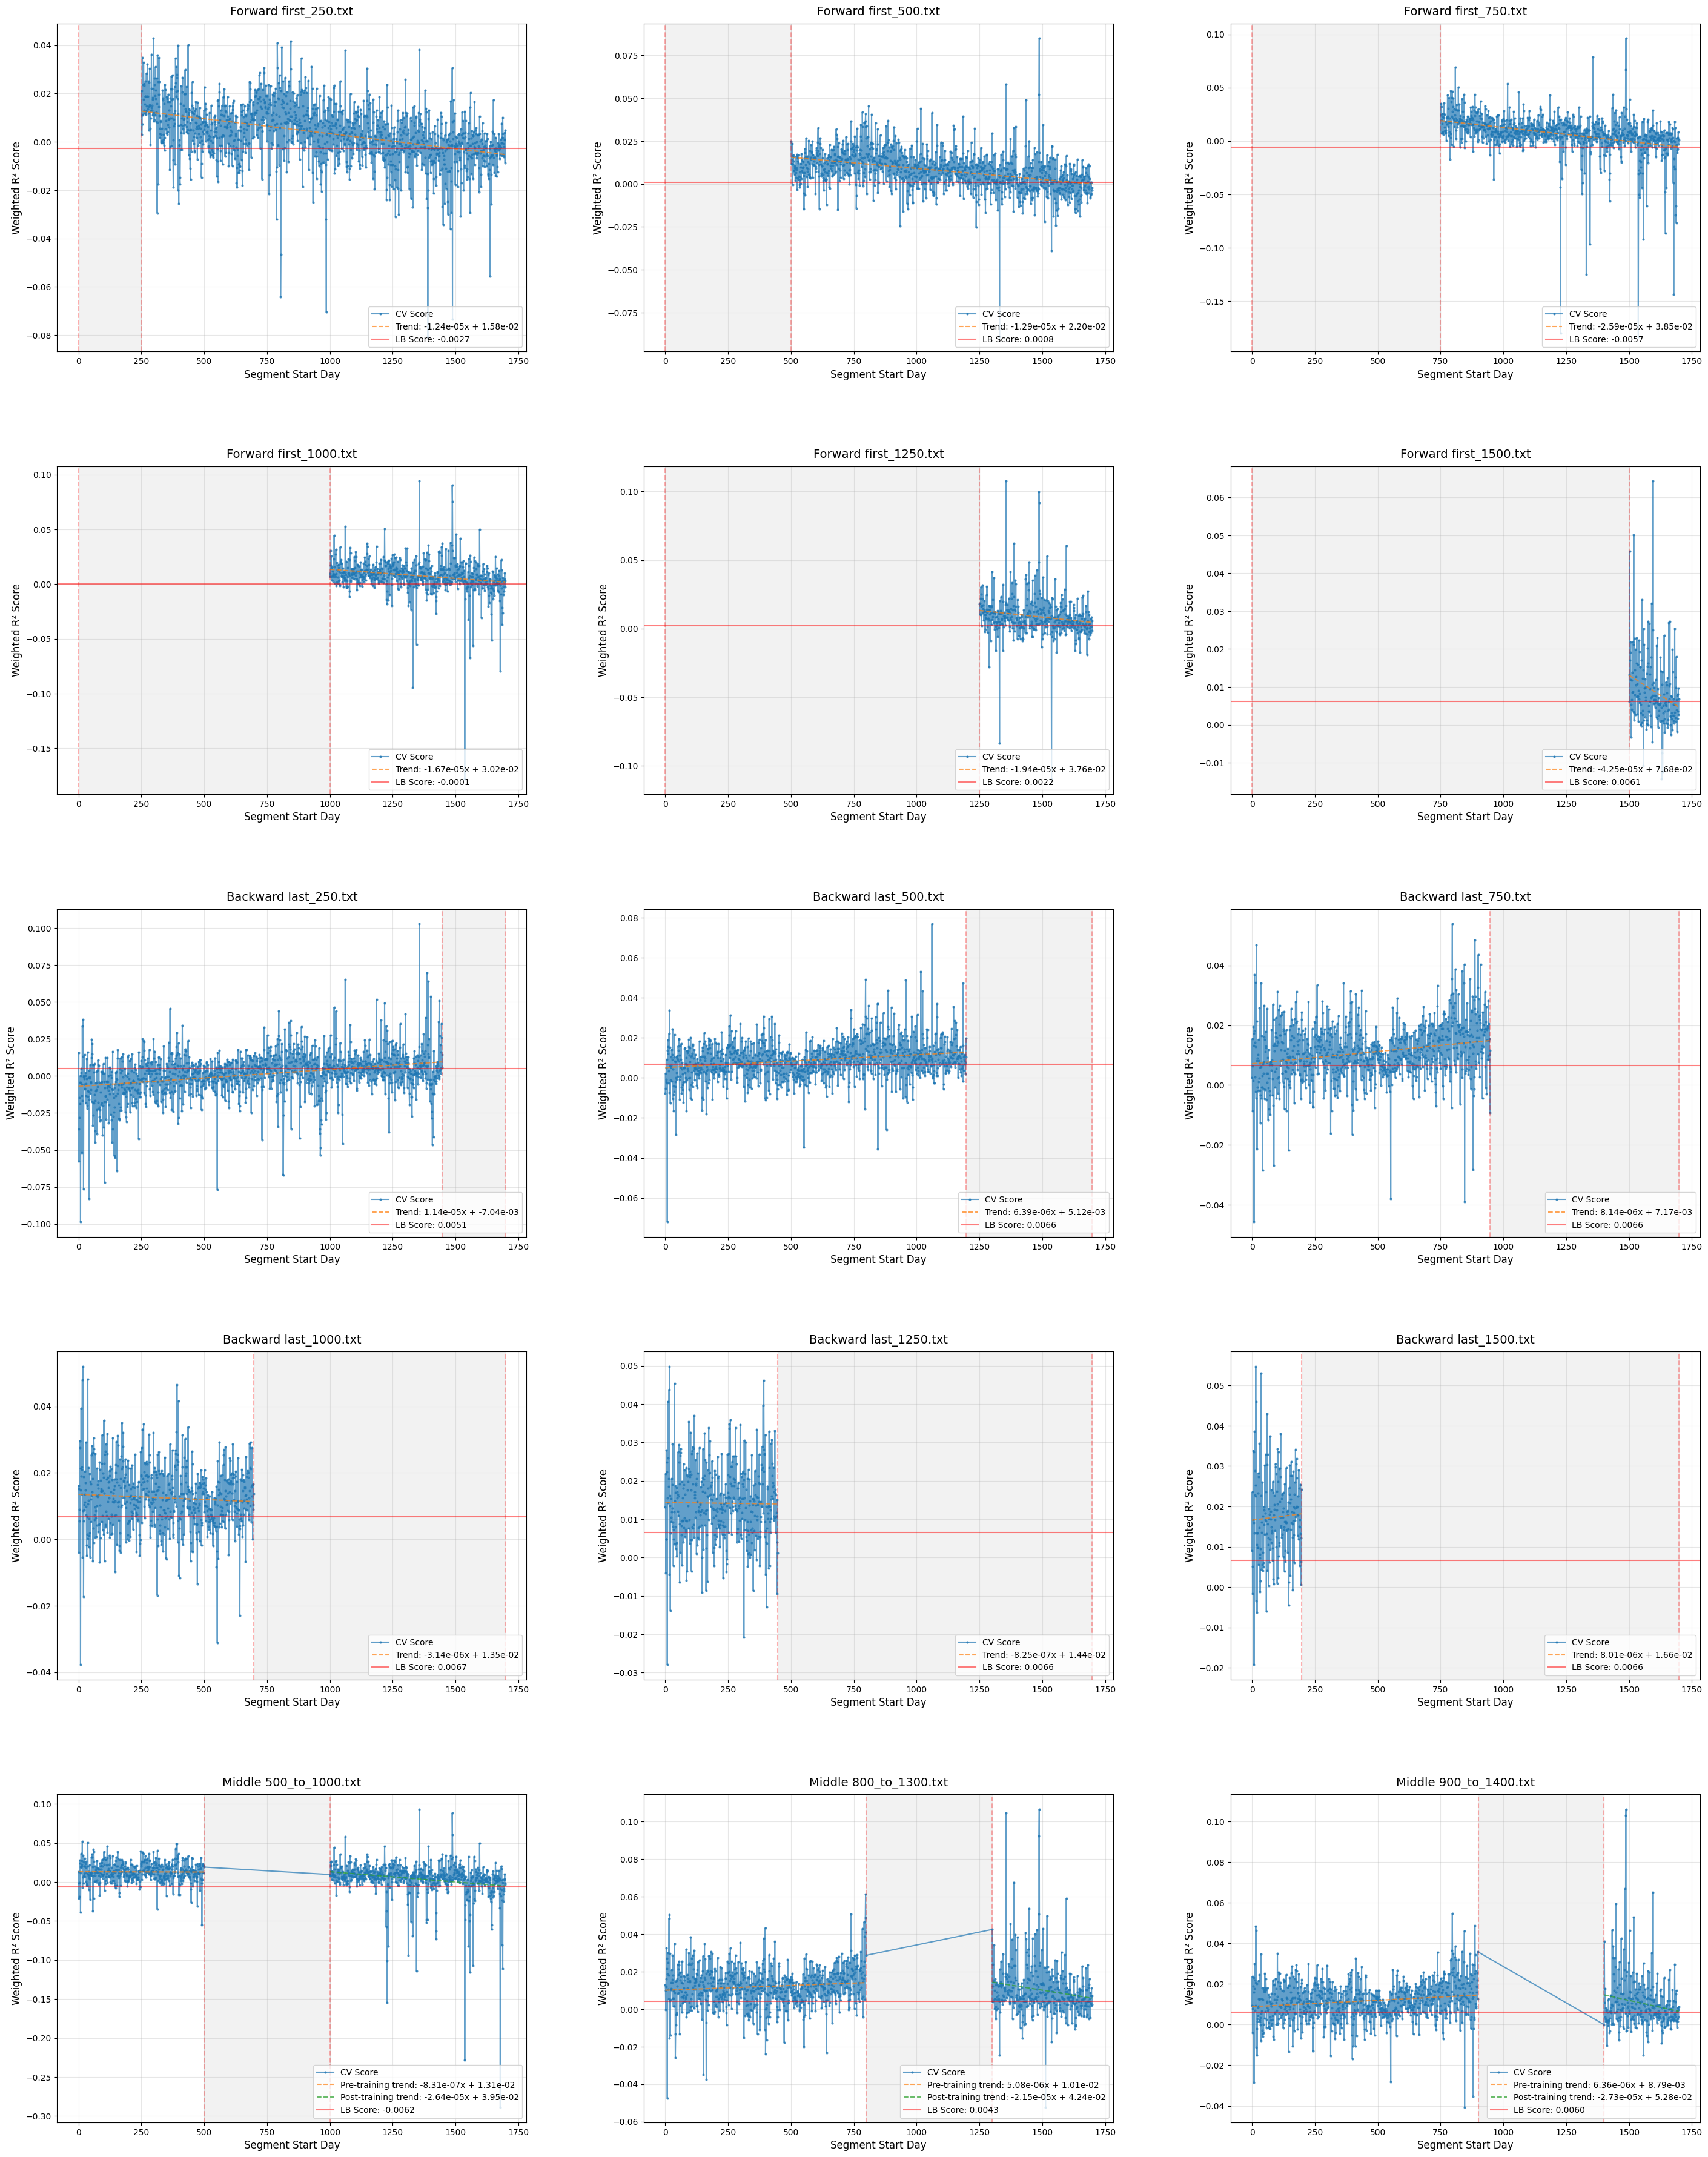

In [43]:
# Define LB scores
LB_SCORES = {
    'first_250.txt': -0.0027,
    'first_500.txt': 0.0008,
    'first_750.txt': -0.0057,
    'first_1000.txt': -0.0001,
    'first_1250.txt': 0.0022,
    'first_1500.txt': 0.0061,
    'last_250.txt': 0.0051,
    'last_500.txt': 0.0066,
    'last_750.txt': 0.0066,
    'last_1000.txt': 0.0067,
    'last_1250.txt': 0.0066,
    'last_1500.txt': 0.0066,
    '500_to_1000.txt': -0.0062,
    '800_to_1300.txt': 0.0043,
    '900_to_1400.txt': 0.0060
}

# Create subplot grid (5x3)
fig = plt.figure(figsize=(35, 45))  # Even bigger
gs = fig.add_gridspec(5, 3, hspace=0.35, wspace=0.25)  # Slightly more spacing
axes = gs.subplots(squeeze=True).flatten()

# For correlation analysis
cv_lb_comparison = {
    'model_name': [],
    'lb_score': [],
    'final_cv_score': []
}

# Plot each model in its own subplot
for idx, model_config in enumerate(MODELS):
    model_name = model_config['name']
    train_start = model_config['train_start']
    train_end = model_config['train_end']
    r2_col = f'r2_score_{model_name}'
    is_forward = model_name.startswith('first')
    is_backward = model_name.startswith('last')
    is_middle = not (is_forward or is_backward)
    lb_score = LB_SCORES[model_name]
    
    # Get valid results
    valid_results = results_df[
        (results_df['start_day'] < train_start) | (results_df['start_day'] > train_end)
    ][['start_day', r2_col]].dropna()
    
    if len(valid_results) > 0:
        cv_lb_comparison['model_name'].append(model_name)
        cv_lb_comparison['lb_score'].append(lb_score)
        cv_lb_comparison['final_cv_score'].append(valid_results[r2_col].iloc[-1])
    
    # Plot scores
    axes[idx].plot(valid_results['start_day'], valid_results[r2_col], 
                  marker='o', markersize=2,
                  label='CV Score', alpha=0.7)
    
    # Add trend line(s)
    if len(valid_results) > 0:
        if is_middle:
            # Split into before and after training period
            before_results = valid_results[valid_results['start_day'] < train_start]
            after_results = valid_results[valid_results['start_day'] > train_end]
            
            # Trend line for before period
            if len(before_results) > 0:
                z = np.polyfit(before_results['start_day'], before_results[r2_col], 1)
                p = np.poly1d(z)
                axes[idx].plot(before_results['start_day'], p(before_results['start_day']), 
                          "--", alpha=0.7,
                          label=f'Pre-training trend: {z[0]:.2e}x + {z[1]:.2e}')
            
            # Trend line for after period
            if len(after_results) > 0:
                z = np.polyfit(after_results['start_day'], after_results[r2_col], 1)
                p = np.poly1d(z)
                axes[idx].plot(after_results['start_day'], p(after_results['start_day']), 
                          "--", alpha=0.7,
                          label=f'Post-training trend: {z[0]:.2e}x + {z[1]:.2e}')
        else:
            z = np.polyfit(valid_results['start_day'], valid_results[r2_col], 1)
            p = np.poly1d(z)
            axes[idx].plot(valid_results['start_day'], p(valid_results['start_day']), 
                      "--", alpha=0.7,
                      label=f'Trend: {z[0]:.2e}x + {z[1]:.2e}')
    
    # Add LB score line
    axes[idx].axhline(y=lb_score, color='r', linestyle='-', 
                     label=f'LB Score: {lb_score:.4f}', alpha=0.5)
    
    # Add vertical lines showing training period
    axes[idx].axvline(x=train_start, color='r', linestyle='--', alpha=0.3)
    axes[idx].axvline(x=train_end, color='r', linestyle='--', alpha=0.3)
    axes[idx].axvspan(train_start, train_end, color='gray', alpha=0.1)
    
    # Customize subplot
    model_type = "Forward" if is_forward else ("Backward" if is_backward else "Middle")
    axes[idx].set_title(f'{model_type} {model_name}', fontsize=14, pad=10)
    axes[idx].set_xlabel('Segment Start Day', fontsize=12)
    axes[idx].set_ylabel('Weighted R² Score', fontsize=12)
    axes[idx].tick_params(axis='both', labelsize=10)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend(loc='lower right', fontsize=10)  # Fixed legend position

# Remove extra subplots
for idx in range(len(MODELS), len(axes)):
    fig.delaxes(axes[idx])

plt.show()

## It looks like there is a consistent drop-off between ALL models for their post-training data points. We can use this to weight our validation and better estimate true LB scores!

In [39]:
# Store pre and post trend lines separately
pre_trends = {}
post_trends = {}

for model_config in MODELS:
    model_name = model_config['name']
    train_start = model_config['train_start']
    train_end = model_config['train_end']
    r2_col = f'r2_score_{model_name}'
    is_forward = model_name.startswith('first')
    is_backward = model_name.startswith('last')
    is_middle = not (is_forward or is_backward)
    
    # Get valid results
    valid_results = results_df[
        (results_df['start_day'] < train_start) | (results_df['start_day'] > train_end)
    ][['start_day', r2_col]].dropna()
    
    if len(valid_results) > 0:
        if is_middle:
            # Split into before and after training period
            before_results = valid_results[valid_results['start_day'] < train_start]
            after_results = valid_results[valid_results['start_day'] > train_end]
            
            # Trend line for before period
            if len(before_results) > 0:
                z = np.polyfit(before_results['start_day'], before_results[r2_col], 1)
                pre_trends[f"{model_name}"] = {
                    'slope': z[0],
                    'intercept': z[1],
                    'days_from_edge': before_results['start_day'] - train_start
                }
            
            # Trend line for after period
            if len(after_results) > 0:
                z = np.polyfit(after_results['start_day'], after_results[r2_col], 1)
                post_trends[f"{model_name}"] = {
                    'slope': z[0],
                    'intercept': z[1],
                    'days_from_edge': after_results['start_day'] - train_end
                }
        else:
            z = np.polyfit(valid_results['start_day'], valid_results[r2_col], 1)
            if is_forward:
                post_trends[model_name] = {
                    'slope': z[0],
                    'intercept': z[1],
                    'days_from_edge': valid_results['start_day'] - train_end
                }
            else:  # backward
                pre_trends[model_name] = {
                    'slope': z[0],
                    'intercept': z[1],
                    'days_from_edge': valid_results['start_day'] - train_start
                }

# Print pre-training trend lines
print("Pre-training trend lines (predictions before training period):")
print("-" * 80)
print(f"{'Model':<20} {'Slope':<15} {'Intercept':<15} {'Avg Days from Edge':<20}")
print("-" * 80)

sorted_pre = sorted(pre_trends.items(), key=lambda x: abs(x[1]['slope']), reverse=True)
for model_name, trend in sorted_pre:
    avg_days = np.mean(abs(trend['days_from_edge']))
    print(f"{model_name:<20} {trend['slope']:.2e} {trend['intercept']:.2e} {avg_days:.1f}")

pre_slopes = [trend['slope'] for trend in pre_trends.values()]
print(f"\nPre-training average slope: {np.mean(pre_slopes):.2e}")
print(f"Pre-training slope std dev: {np.std(pre_slopes):.2e}")

# Print post-training trend lines
print("\nPost-training trend lines (predictions after training period):")
print("-" * 80)
print(f"{'Model':<20} {'Slope':<15} {'Intercept':<15} {'Avg Days from Edge':<20}")
print("-" * 80)

sorted_post = sorted(post_trends.items(), key=lambda x: abs(x[1]['slope']), reverse=True)
for model_name, trend in sorted_post:
    avg_days = np.mean(abs(trend['days_from_edge']))
    print(f"{model_name:<20} {trend['slope']:.2e} {trend['intercept']:.2e} {avg_days:.1f}")

post_slopes = [trend['slope'] for trend in post_trends.values()]
print(f"\nPost-training average slope: {np.mean(post_slopes):.2e}")
print(f"Post-training slope std dev: {np.std(post_slopes):.2e}")

Pre-training trend lines (predictions before training period):
--------------------------------------------------------------------------------
Model                Slope           Intercept       Avg Days from Edge  
--------------------------------------------------------------------------------
last_250.txt         1.14e-05 -7.04e-03 724.5
last_750.txt         8.14e-06 7.17e-03 474.5
last_1500.txt        8.01e-06 1.66e-02 99.5
last_500.txt         6.39e-06 5.12e-03 599.5
900_to_1400.txt      6.36e-06 8.79e-03 450.5
800_to_1300.txt      5.08e-06 1.01e-02 400.5
last_1000.txt        -3.14e-06 1.35e-02 349.5
500_to_1000.txt      -8.31e-07 1.31e-02 250.5
last_1250.txt        -8.25e-07 1.44e-02 224.5

Pre-training average slope: 4.51e-06
Pre-training slope std dev: 4.67e-06

Post-training trend lines (predictions after training period):
--------------------------------------------------------------------------------
Model                Slope           Intercept       Avg Days from Edge  

### It would be cool if this pattern also went backwards (It would allow me to do more quirky CV stuff), it almost looked like it could have, but I would need more data to confirm.

Model Performance Comparison:
----------------------------------------------------------------------------------------------------
Model           Raw Mean     Raw Std      Projected LB    Proj Std     Actual LB   
----------------------------------------------------------------------------------------------------
first_250.txt    0.0037       0.0123       0.0601          0.0185      -0.0027     
first_500.txt    0.0078       0.0112       0.0614          0.0161       0.0008     
first_750.txt    0.0068       0.0192       0.0575          0.0223      -0.0057     
first_1000.txt   0.0076       0.0157       0.0555          0.0172      -0.0001     
first_1250.txt   0.0089       0.0152       0.0539          0.0160       0.0022     
first_1500.txt   0.0089       0.0097       0.0511          0.0101       0.0061     
500_to_1000.txt  0.0039       0.0248       0.0518          0.0262      -0.0062     
800_to_1300.txt  0.0101       0.0142       0.0546          0.0149       0.0043     
900_to_1400.

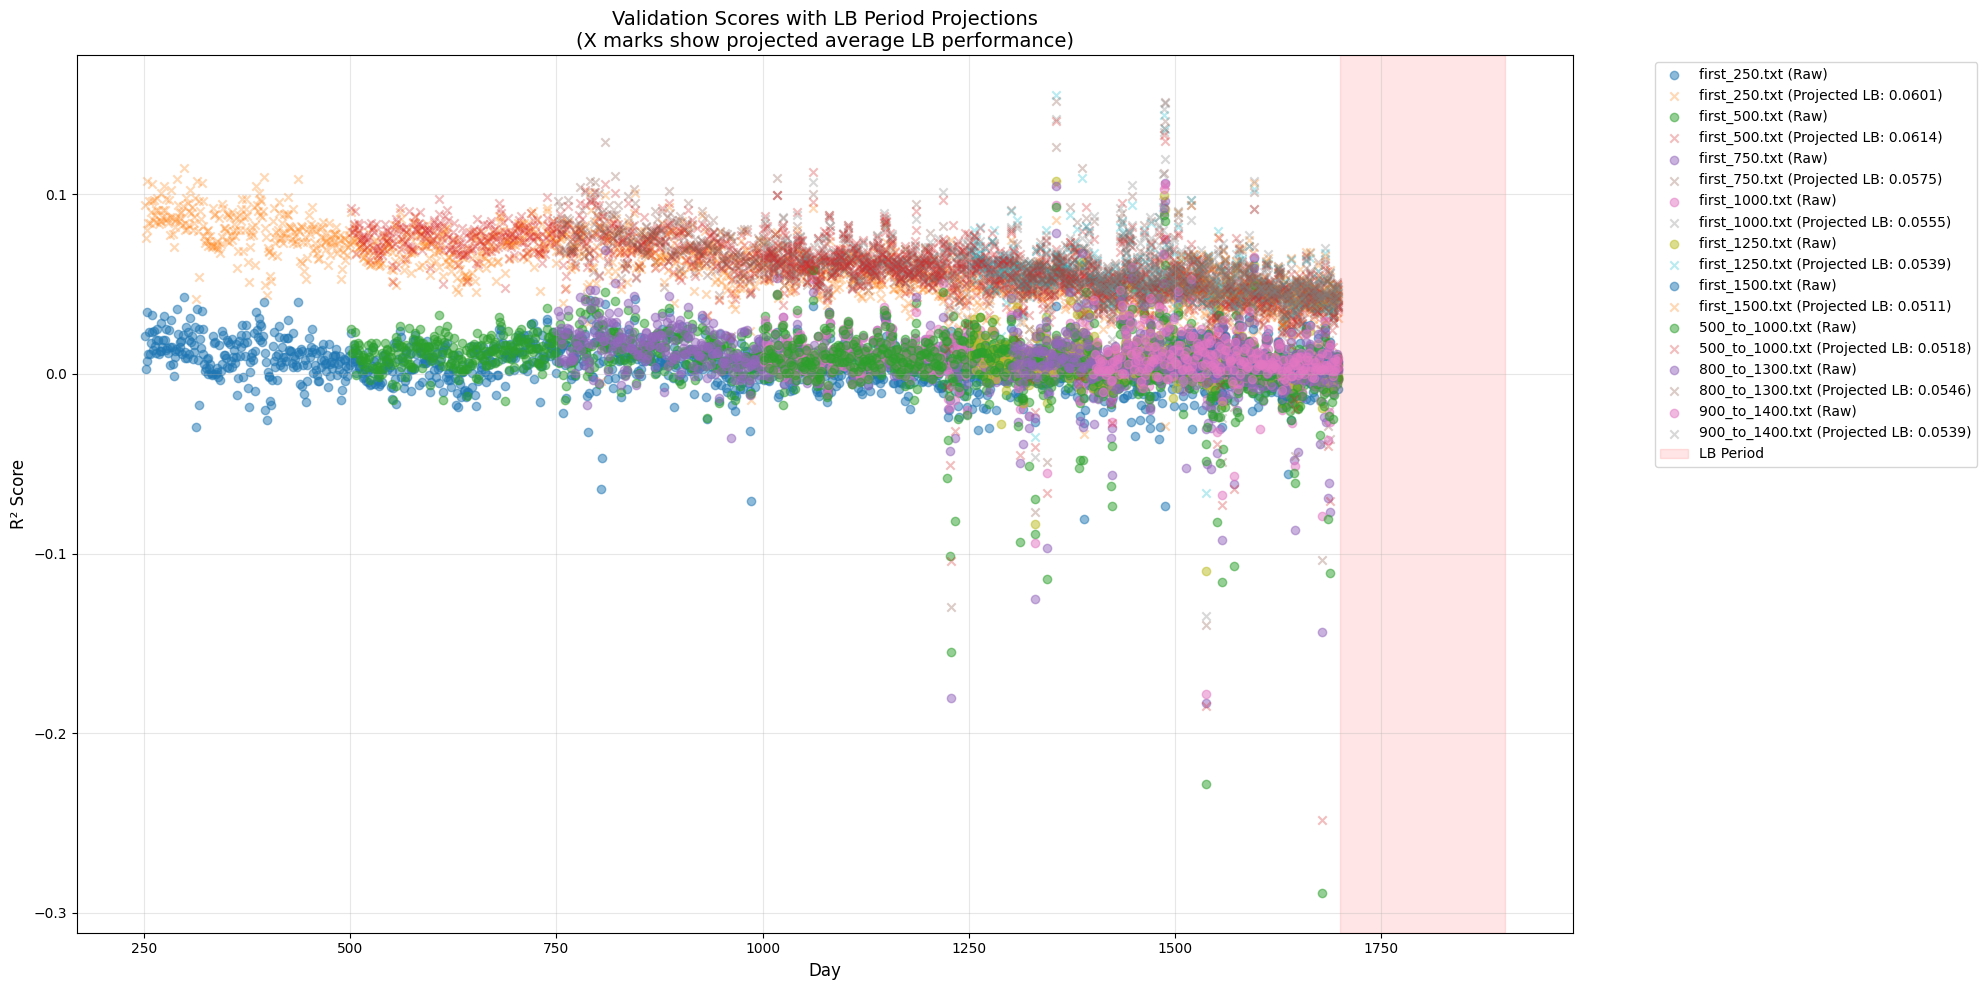

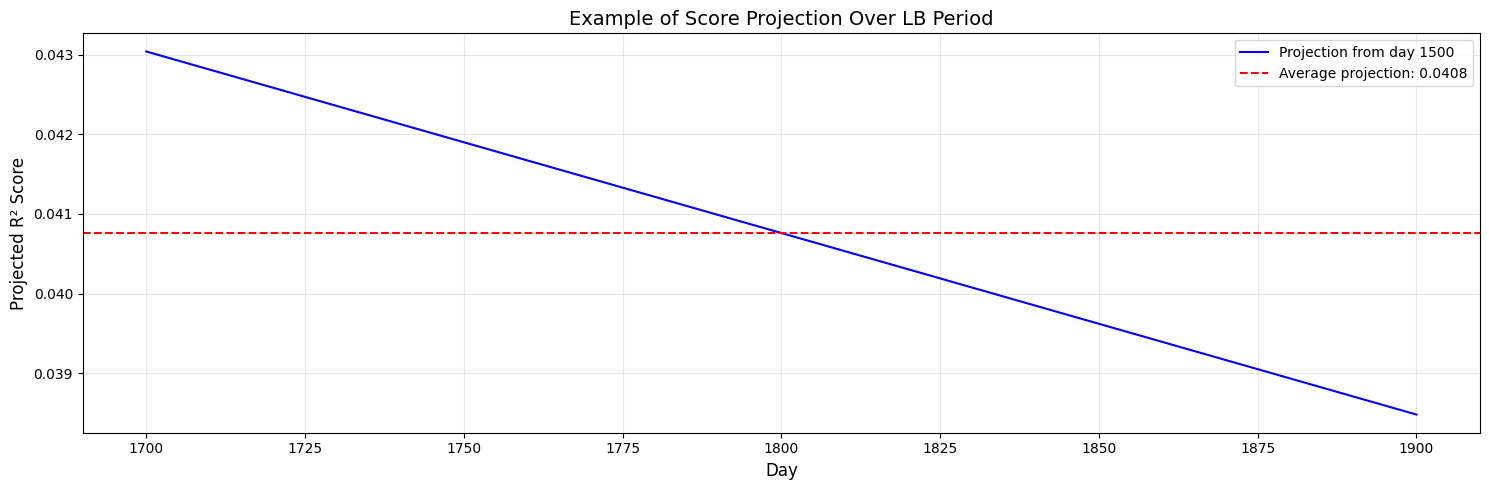

In [ ]:
# Parameters
DECAY_RATE = -2.28e-05  # observed post-training decay rate
AVERAGE_INTERCEPT = 3.76e-02  # we should calculate this from the data
LB_START = 1700
LB_END = 1900

def calculate_lb_period_projection(score, val_day):
    """Calculate average projected performance over LB period"""
    projected_scores = []
    for lb_day in range(LB_START, LB_END + 1):
        days_forward = lb_day - val_day
        projected_score = score + (-DECAY_RATE * days_forward) - AVERAGE_INTERCEPT
        projected_scores.append(projected_score)
    return np.mean(projected_scores)

# Calculate decay-based weights and adjusted scores
weighted_scores = {}
raw_scores = {}

for model_config in MODELS:
    model_name = model_config['name']
    train_start = model_config['train_start']
    train_end = model_config['train_end']
    r2_col = f'r2_score_{model_name}'
    
    # Get post-training validation results only
    valid_results = results_df[
        results_df['start_day'] > train_end
    ][['start_day', r2_col]].dropna()
    
    if len(valid_results) > 0:
        # Calculate projected LB performance for each validation point
        lb_projections = [
            calculate_lb_period_projection(score, day)
            for score, day in zip(valid_results[r2_col], valid_results['start_day'])
        ]
        
        # Store raw and weighted scores
        raw_scores[model_name] = {
            'mean': valid_results[r2_col].mean(),
            'std': valid_results[r2_col].std(),
            'scores': valid_results[r2_col].values,
            'days': valid_results['start_day'].values,
            'projections': lb_projections
        }
        
        weighted_scores[model_name] = {
            'mean': np.mean(lb_projections),
            'std': np.std(lb_projections)
        }

# Print comparison
print("Model Performance Comparison:")
print("-" * 100)
print(f"{'Model':<15} {'Raw Mean':<12} {'Raw Std':<12} {'Projected LB':<15} {'Proj Std':<12} {'Actual LB':<12}")
print("-" * 100)

for model_name in raw_scores.keys():
    print(f"{model_name:<15} "
          f"{raw_scores[model_name]['mean']:< 12.4f} "
          f"{raw_scores[model_name]['std']:< 12.4f} "
          f"{weighted_scores[model_name]['mean']:< 15.4f} "
          f"{weighted_scores[model_name]['std']:< 12.4f} "
          f"{LB_SCORES.get(model_name, 'N/A'):< 12}")

# Visualize original scores and their projections
plt.figure(figsize=(20, 10))

# Plot for each model
for idx, model_name in enumerate(raw_scores.keys()):
    days = raw_scores[model_name]['days']
    scores = raw_scores[model_name]['scores']
    projections = raw_scores[model_name]['projections']
    
    # Plot original scores
    plt.scatter(days, scores, alpha=0.5, label=f'{model_name} (Raw)')
    # Plot projected LB performance
    plt.scatter(days, projections, alpha=0.3, marker='x', 
               label=f'{model_name} (Projected LB: {weighted_scores[model_name]["mean"]:.4f})')

plt.axvspan(LB_START, LB_END, color='red', alpha=0.1, label='LB Period')
plt.title('Validation Scores with LB Period Projections\n(X marks show projected average LB performance)', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot example projections for a single validation point
example_day = 1500
example_score = 0.01
projected_days = np.arange(LB_START, LB_END + 1)
projected_scores = [example_score + (DECAY_RATE * (d - example_day)) + AVERAGE_INTERCEPT for d in projected_days]

plt.figure(figsize=(15, 5))
plt.plot(projected_days, projected_scores, 'b-', label=f'Projection from day {example_day}')
plt.axhline(y=np.mean(projected_scores), color='r', linestyle='--', 
           label=f'Average projection: {np.mean(projected_scores):.4f}')
plt.title('Example of Score Projection Over LB Period', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Projected R² Score', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

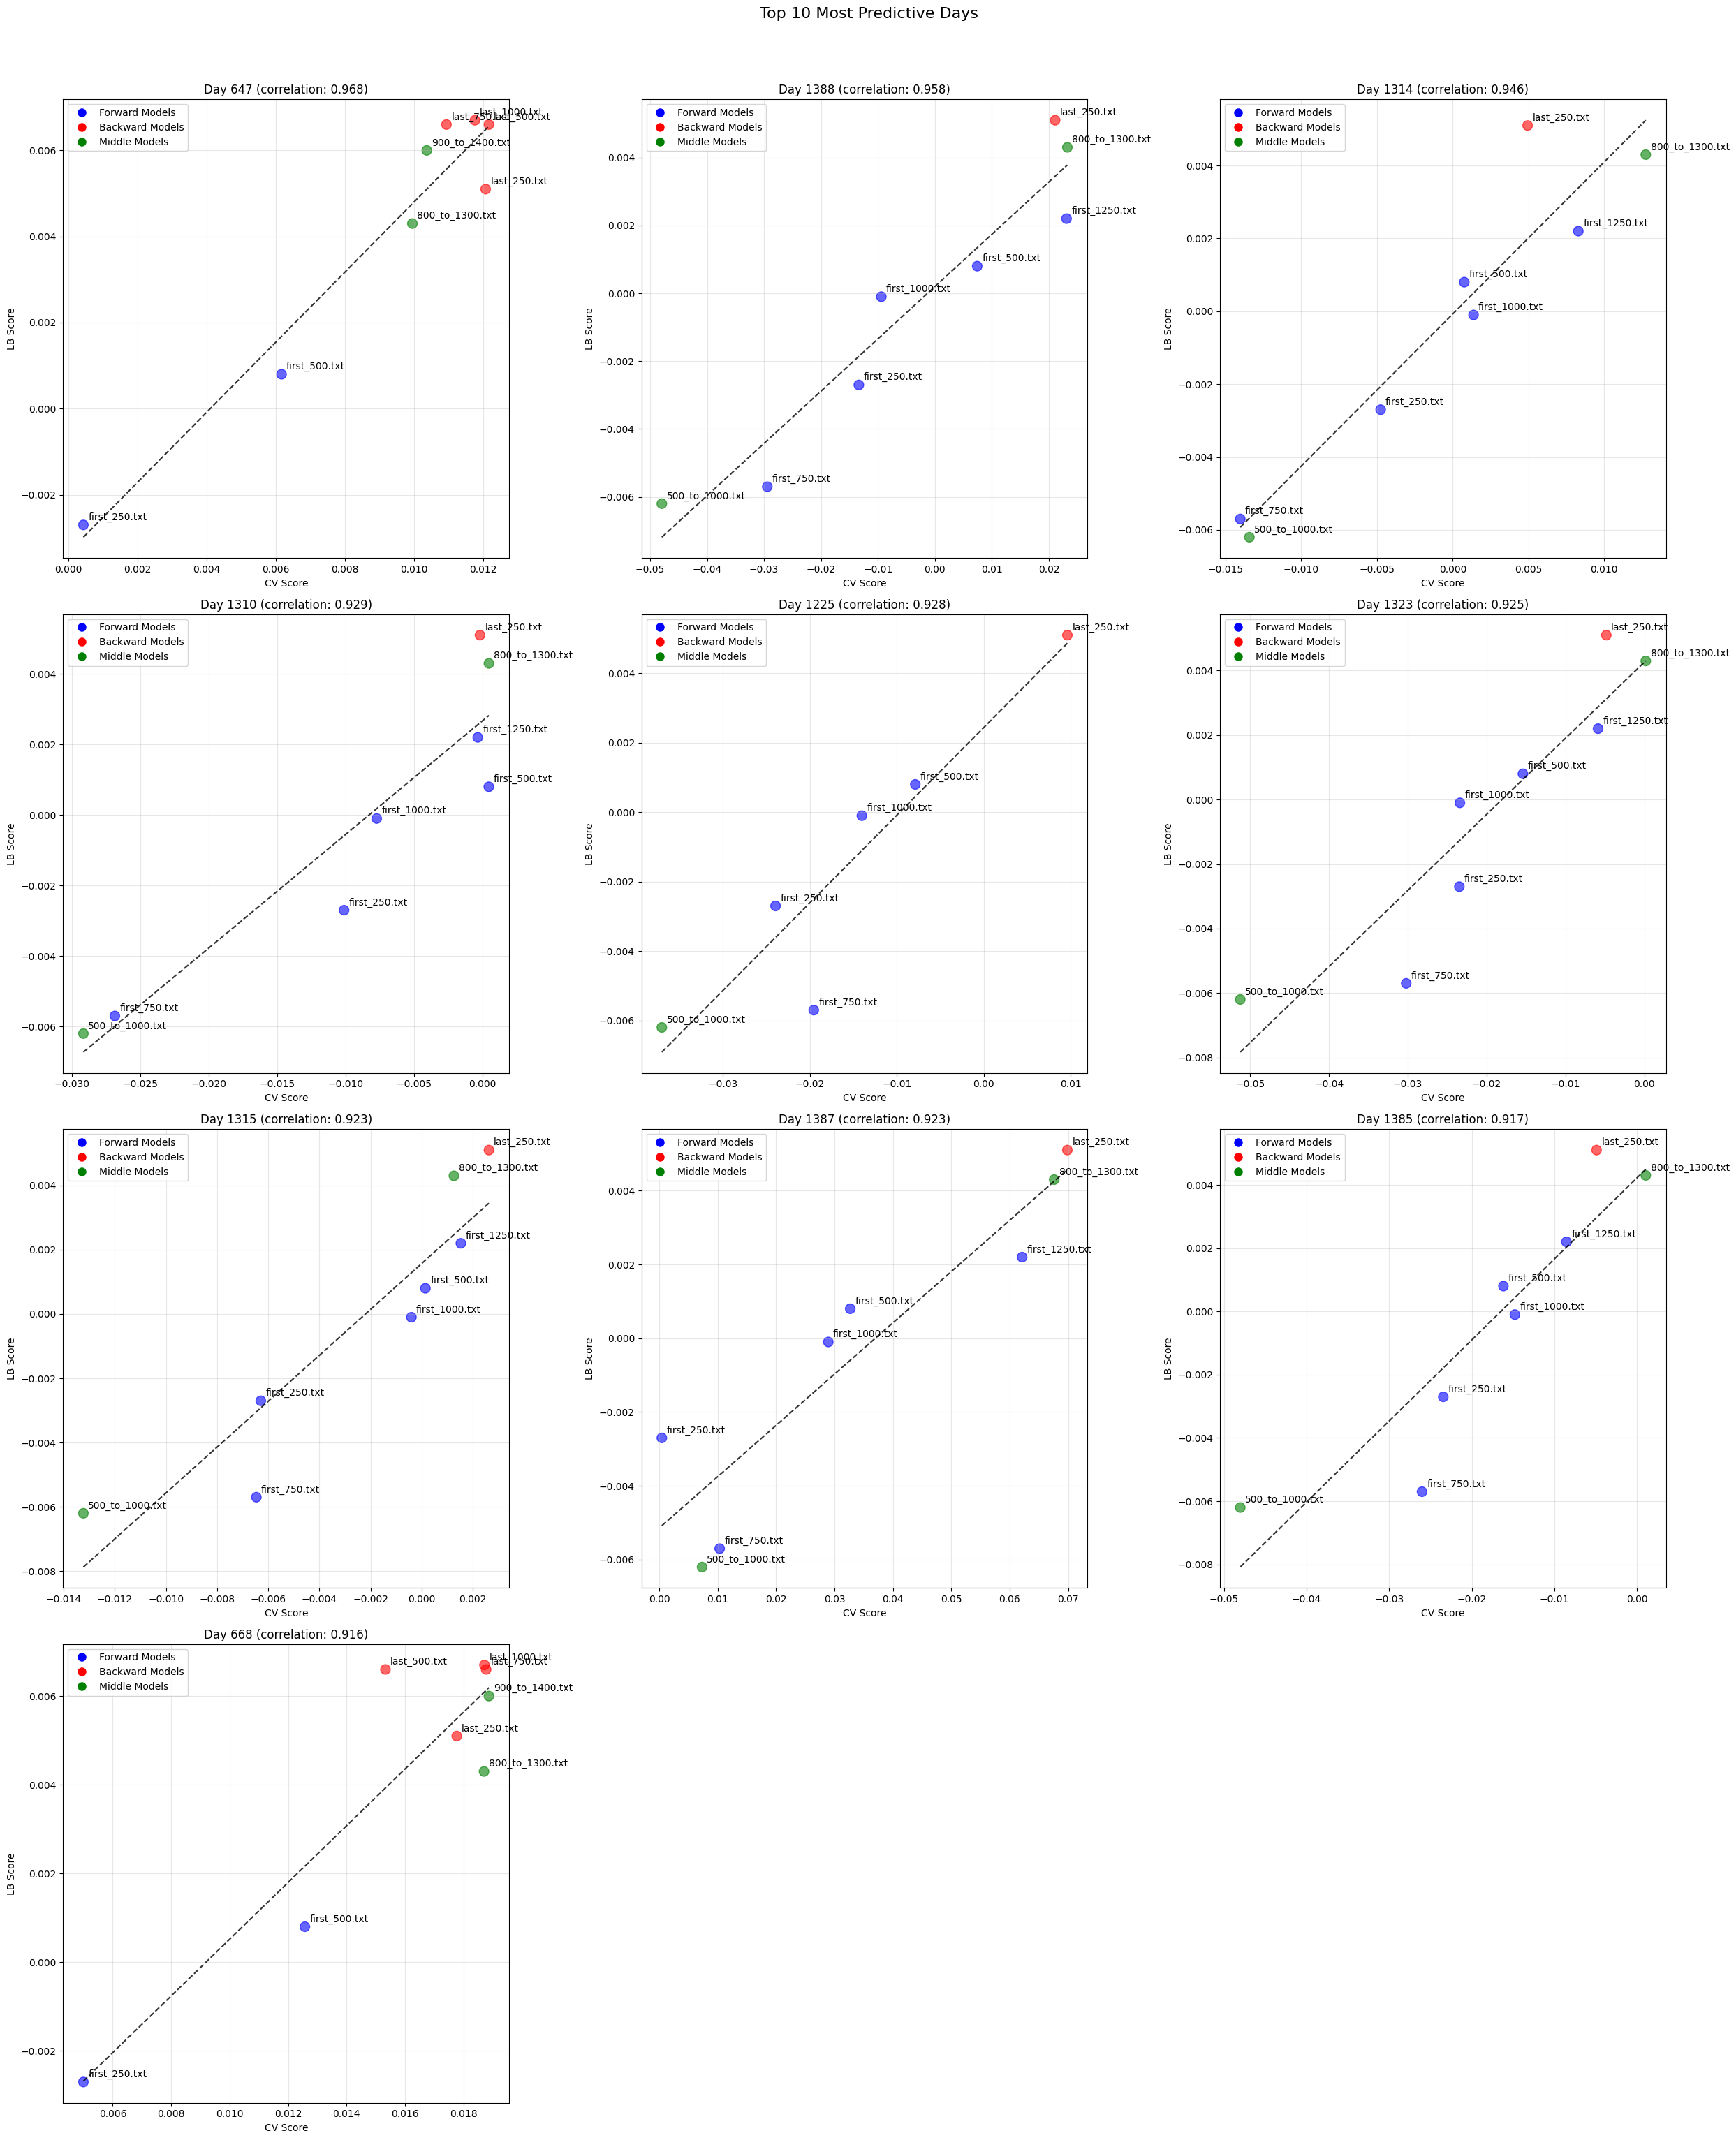

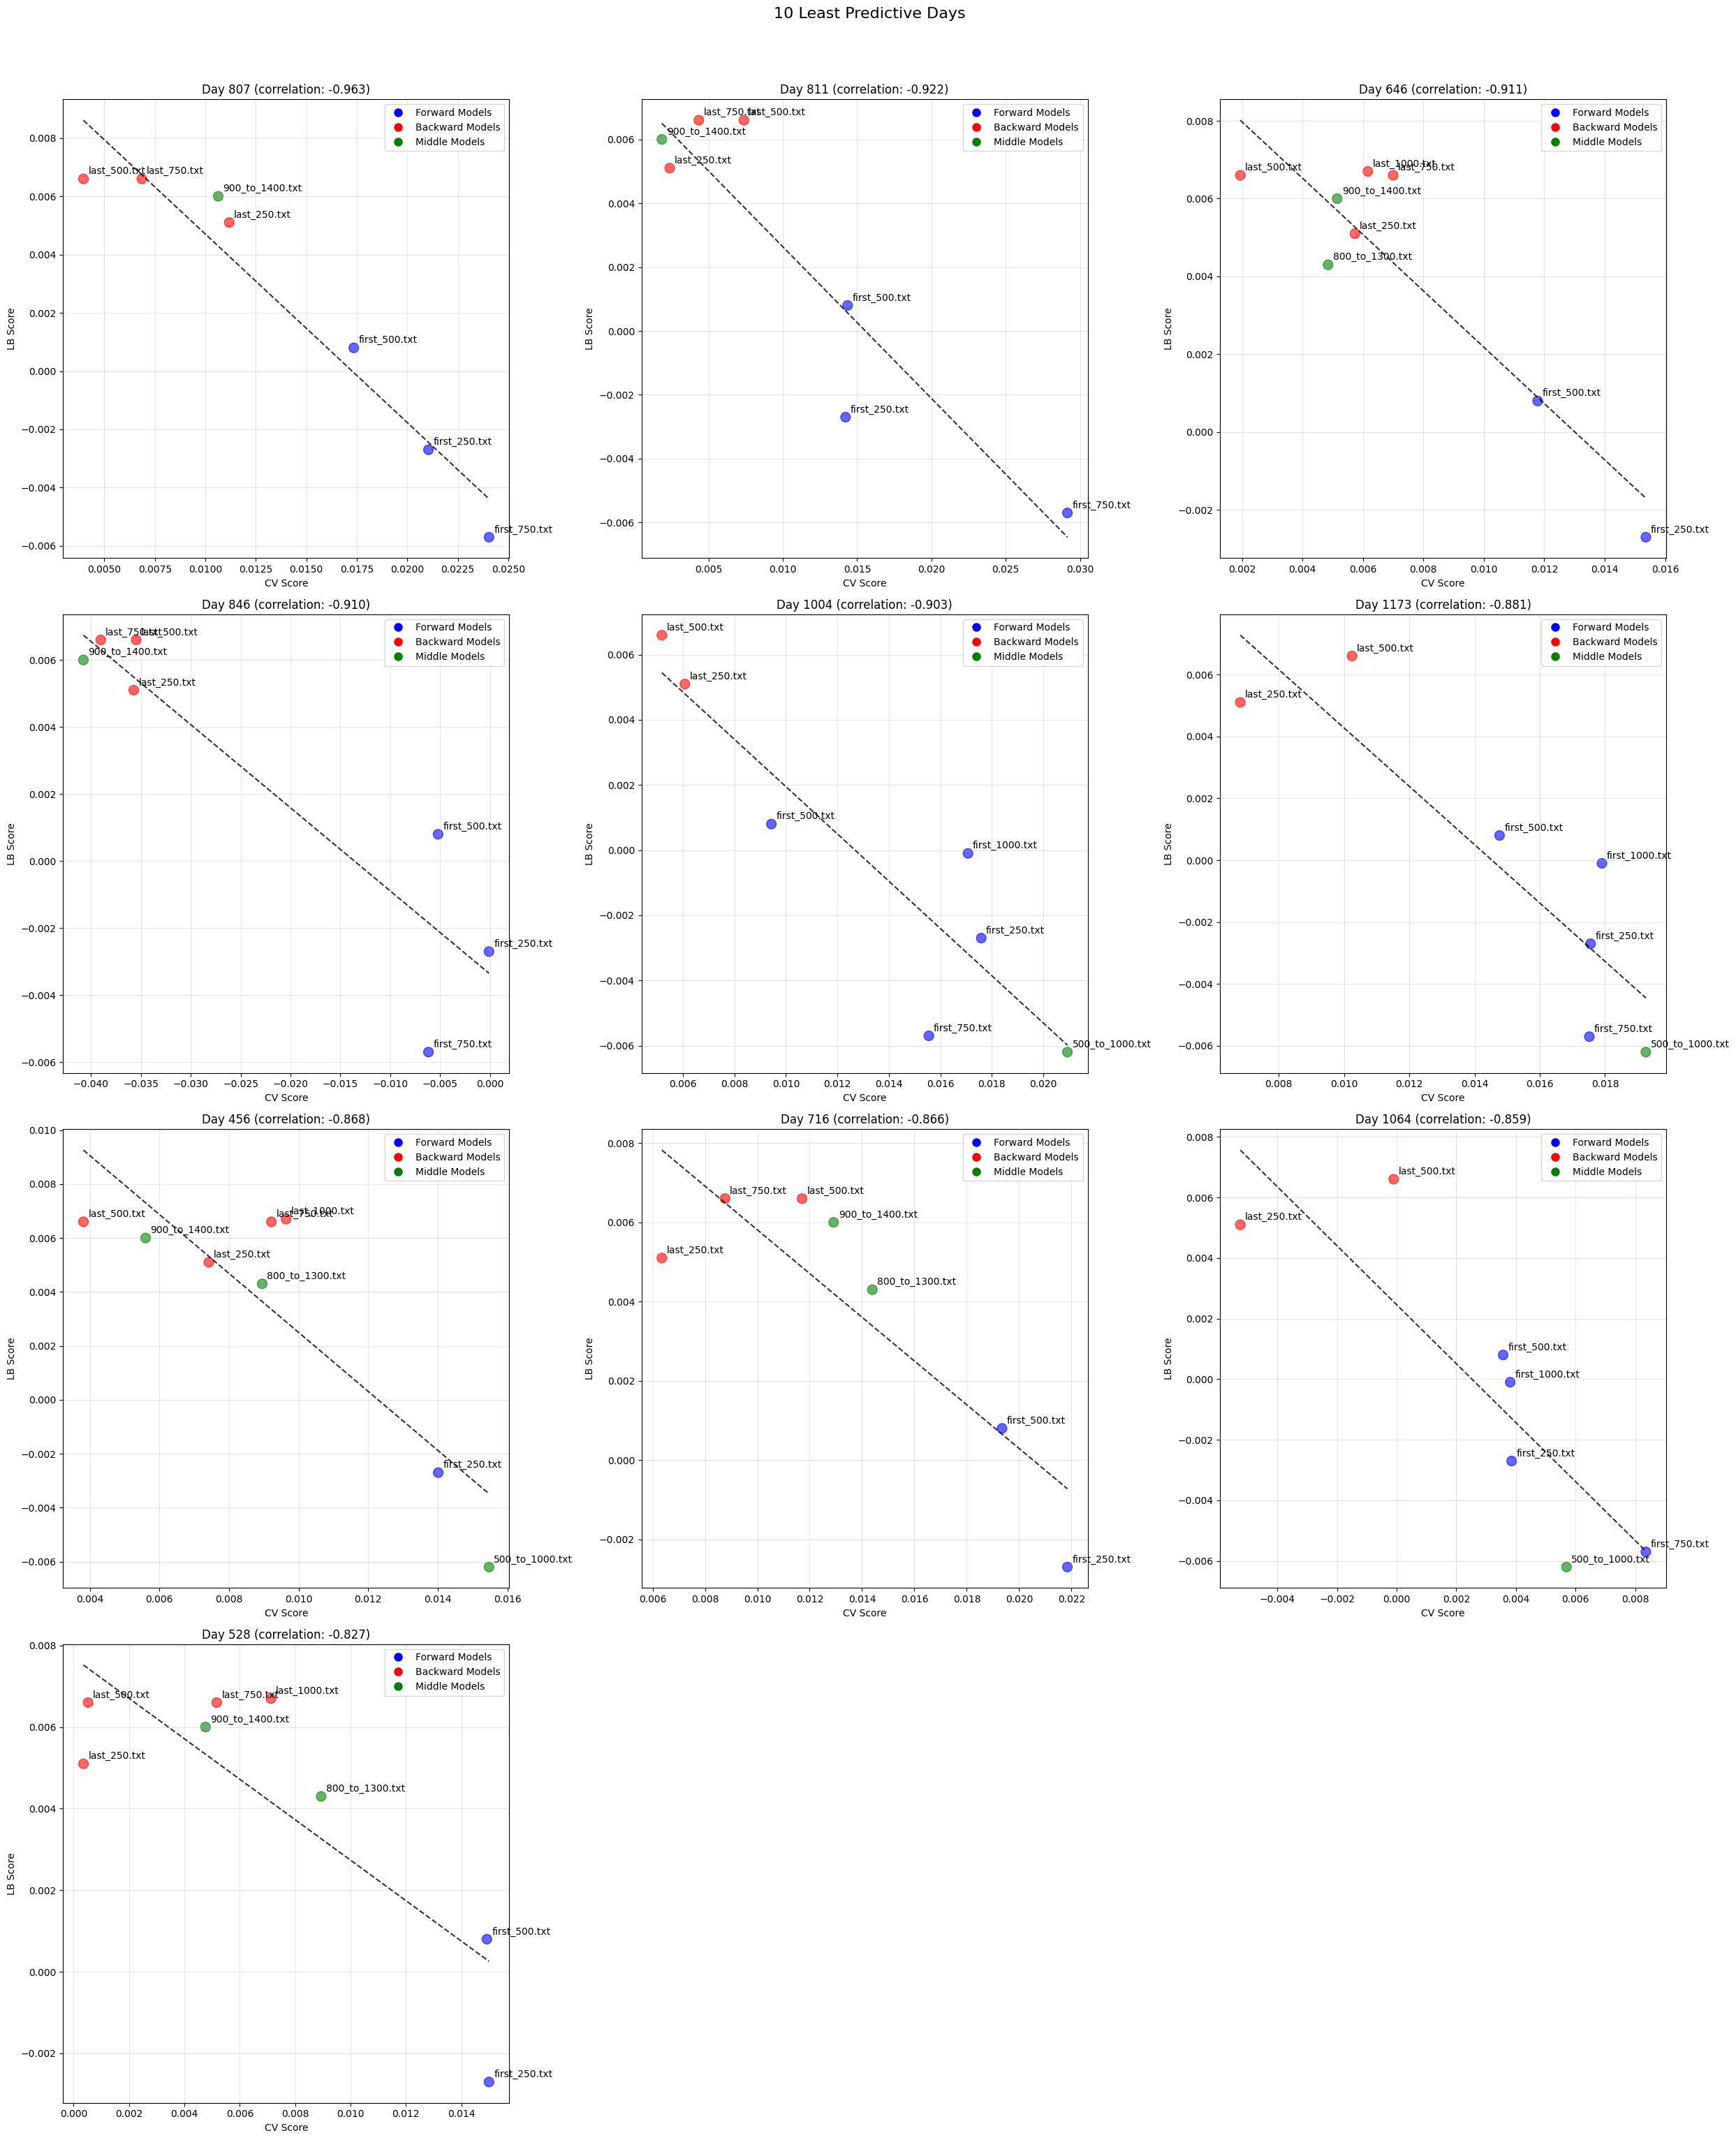


Total qualifying days: 1096
Average correlation: 0.010
Correlation std dev: 0.450

Top 10 most predictive days:
--------------------------------------------------------------------------------

Day 647 (correlation: 0.968):
         800_to_1300.txt CV:  0.0099    LB:  0.0043   
         900_to_1400.txt CV:  0.0104    LB:  0.0060   
         first_250.txt   CV:  0.0004    LB: -0.0027   
         first_500.txt   CV:  0.0062    LB:  0.0008   
         last_1000.txt   CV:  0.0118    LB:  0.0067   
         last_250.txt    CV:  0.0121    LB:  0.0051   
         last_500.txt    CV:  0.0122    LB:  0.0066   
         last_750.txt    CV:  0.0109    LB:  0.0066   

Day 1388 (correlation: 0.958):
         500_to_1000.txt CV: -0.0479    LB: -0.0062   
         800_to_1300.txt CV:  0.0232    LB:  0.0043   
         first_1000.txt  CV: -0.0094    LB: -0.0001   
         first_1250.txt  CV:  0.0231    LB:  0.0022   
         first_250.txt   CV: -0.0134    LB: -0.0027   
         first_500.txt   CV:

In [33]:
# Calculate correlation for each day
day_correlations = {}
day_predictions = {}  # Store predictions for each day

for day in sorted(results_df['start_day'].unique()):
    day_scores = []
    lb_scores = []
    model_predictions = {}  # Store predictions for this specific day
    model_types = set()
    
    for model_config in MODELS:
        model_name = model_config['name']
        train_start = model_config['train_start']
        train_end = model_config['train_end']
        r2_col = f'r2_score_{model_name}'
        
        # Check if this day is valid (outside training period)
        if day < train_start or day > train_end:
            # Get score for this day
            day_score = results_df[results_df['start_day'] == day][r2_col].iloc[0] \
                if len(results_df[results_df['start_day'] == day]) > 0 else None
            
            if day_score is not None:
                day_scores.append(day_score)
                lb_scores.append(LB_SCORES[model_name])
                model_predictions[model_name] = (day_score, LB_SCORES[model_name])
                
                if model_name.startswith('first'):
                    model_types.add('forward')
                elif model_name.startswith('last'):
                    model_types.add('backward')
                else:
                    model_types.add('middle')
    
    # Calculate correlation if we have enough diverse models (at least 2 types)
    if len(model_types) >= 3:
        correlation = np.corrcoef(day_scores, lb_scores)[0,1]
        day_correlations[day] = correlation
        day_predictions[day] = model_predictions

# Get best and worst days by correlation
top_days = sorted(day_correlations.items(), key=lambda x: x[1], reverse=True)[:10]
bottom_days = sorted(day_correlations.items(), key=lambda x: x[1])[:10]

# Function to create scatter plot for a day
def plot_day_correlation(ax, day, correlation, predictions, title_prefix="Day"):
    day_scores = []
    lb_scores = []
    labels = []
    colors = []
    
    # Sort and prepare data
    sorted_predictions = sorted(predictions.items())
    for model_name, (day_score, lb_score) in sorted_predictions:
        day_scores.append(day_score)
        lb_scores.append(lb_score)
        labels.append(model_name)
        if model_name.startswith('first'):
            colors.append('blue')
        elif model_name.startswith('last'):
            colors.append('red')
        else:
            colors.append('green')
    
    # Create scatter plot
    scatter = ax.scatter(day_scores, lb_scores, c=colors, alpha=0.6, s=100)
    
    # Add trend line
    z = np.polyfit(day_scores, lb_scores, 1)
    p = np.poly1d(z)
    x_range = np.linspace(min(day_scores), max(day_scores), 100)
    ax.plot(x_range, p(x_range), "--", color='black', alpha=0.8, 
            label=f'Trend: y = {z[0]:.4f}x + {z[1]:.4f}')
    
    # Add labels
    for i, label in enumerate(labels):
        ax.annotate(label, (day_scores[i], lb_scores[i]), 
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=10)
    
    # Customize plot
    ax.set_title(f'{title_prefix} {day} (correlation: {correlation:.3f})', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('CV Score', fontsize=10)
    ax.set_ylabel('LB Score', fontsize=10)
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
                  label='Forward Models', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                  label='Backward Models', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', 
                  label='Middle Models', markersize=10)
    ]
    ax.legend(handles=legend_elements, loc='best', fontsize=10)

# Create subplot figures
fig, axes = plt.subplots(4, 3, figsize=(25, 30))
fig.suptitle('Top 10 Most Predictive Days', fontsize=16, y=1.02)
axes = axes.flatten()

for idx, (day, correlation) in enumerate(top_days):
    plot_day_correlation(axes[idx], day, correlation, day_predictions[day])

# Remove empty subplots
for idx in range(10, 12):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Create subplot figure for worst days
fig, axes = plt.subplots(4, 3, figsize=(25, 30))
fig.suptitle('10 Least Predictive Days', fontsize=16, y=1.02)
axes = axes.flatten()

for idx, (day, correlation) in enumerate(bottom_days):
    plot_day_correlation(axes[idx], day, correlation, day_predictions[day])

# Remove empty subplots
for idx in range(10, 12):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Print details
print(f"\nTotal qualifying days: {len(day_correlations)}")
print(f"Average correlation: {np.mean(list(day_correlations.values())):.3f}")
print(f"Correlation std dev: {np.std(list(day_correlations.values())):.3f}")

# Print top and bottom days
for title, days in [("Top 10 most predictive days:", top_days), 
                   ("Bottom 10 least predictive days:", bottom_days)]:
    print(f"\n{title}")
    print("-" * 80)
    for day, correlation in days:
        print(f"\nDay {day} (correlation: {correlation:.3f}):")
        predictions = day_predictions[day]
        for model_name, (day_score, lb_score) in sorted(predictions.items()):
            print(f"{'':<8} {model_name:<15} CV: {day_score:< 10.4f} LB: {lb_score:< 10.4f}")

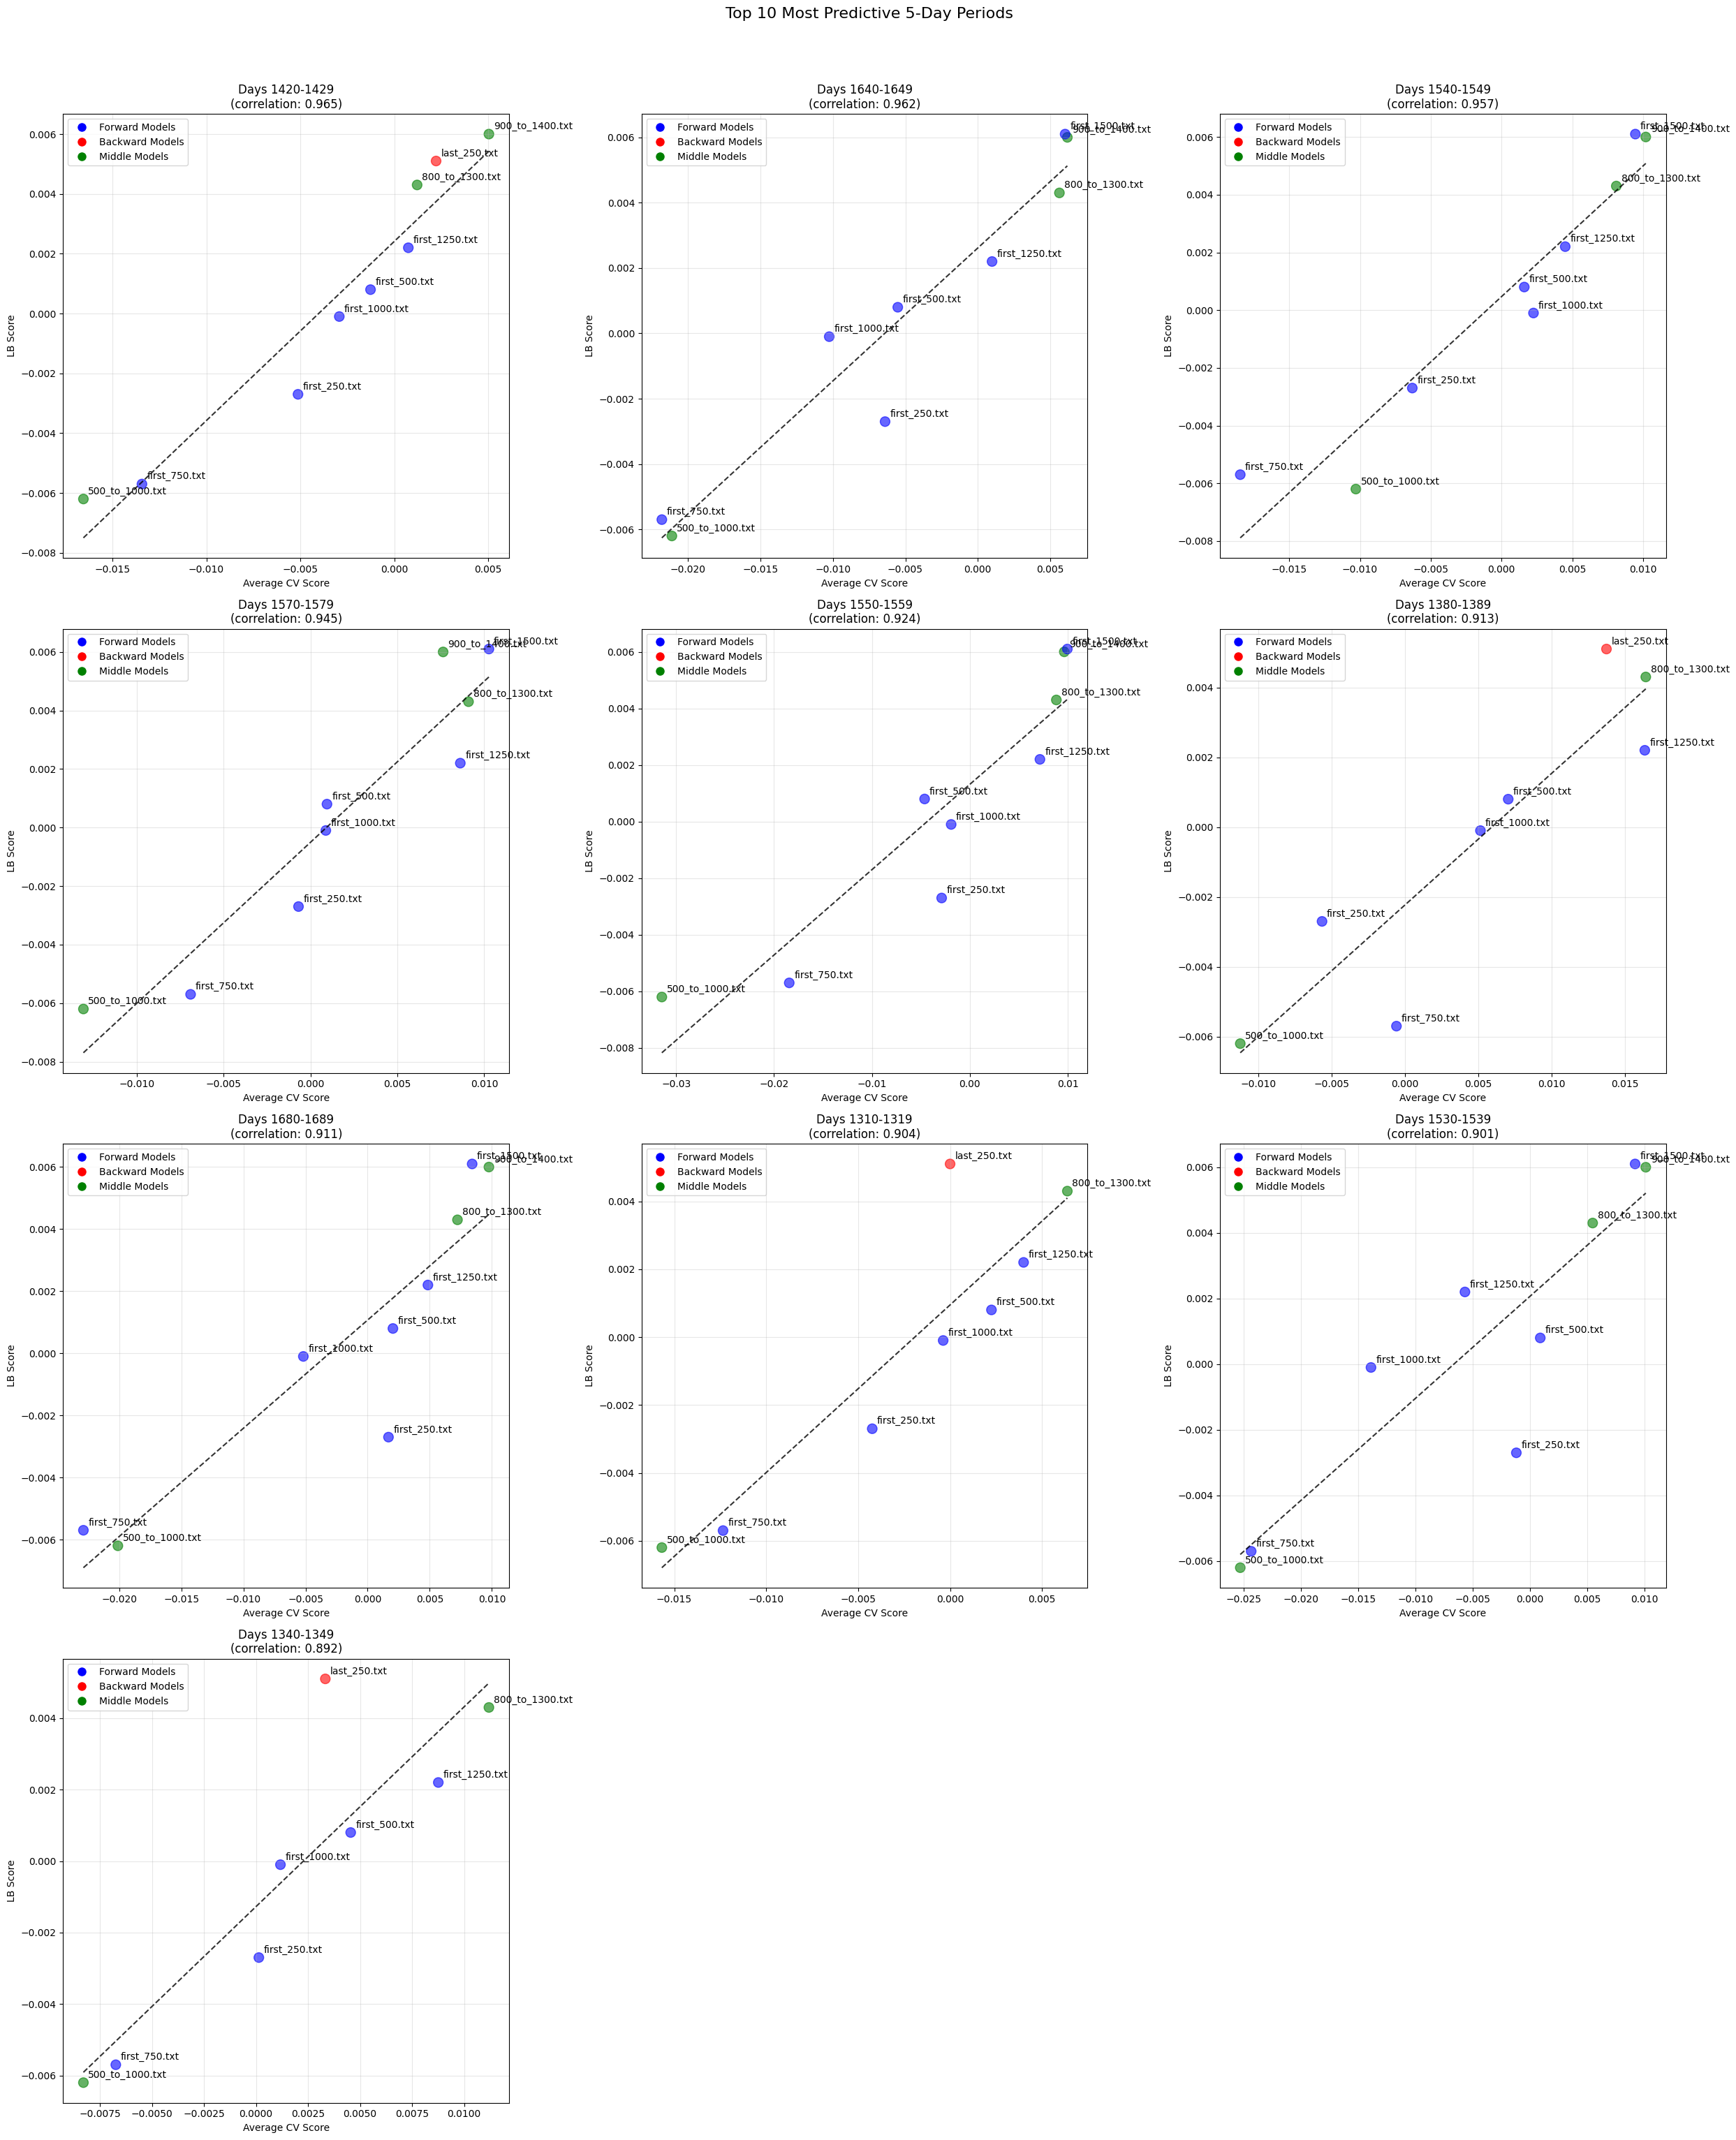

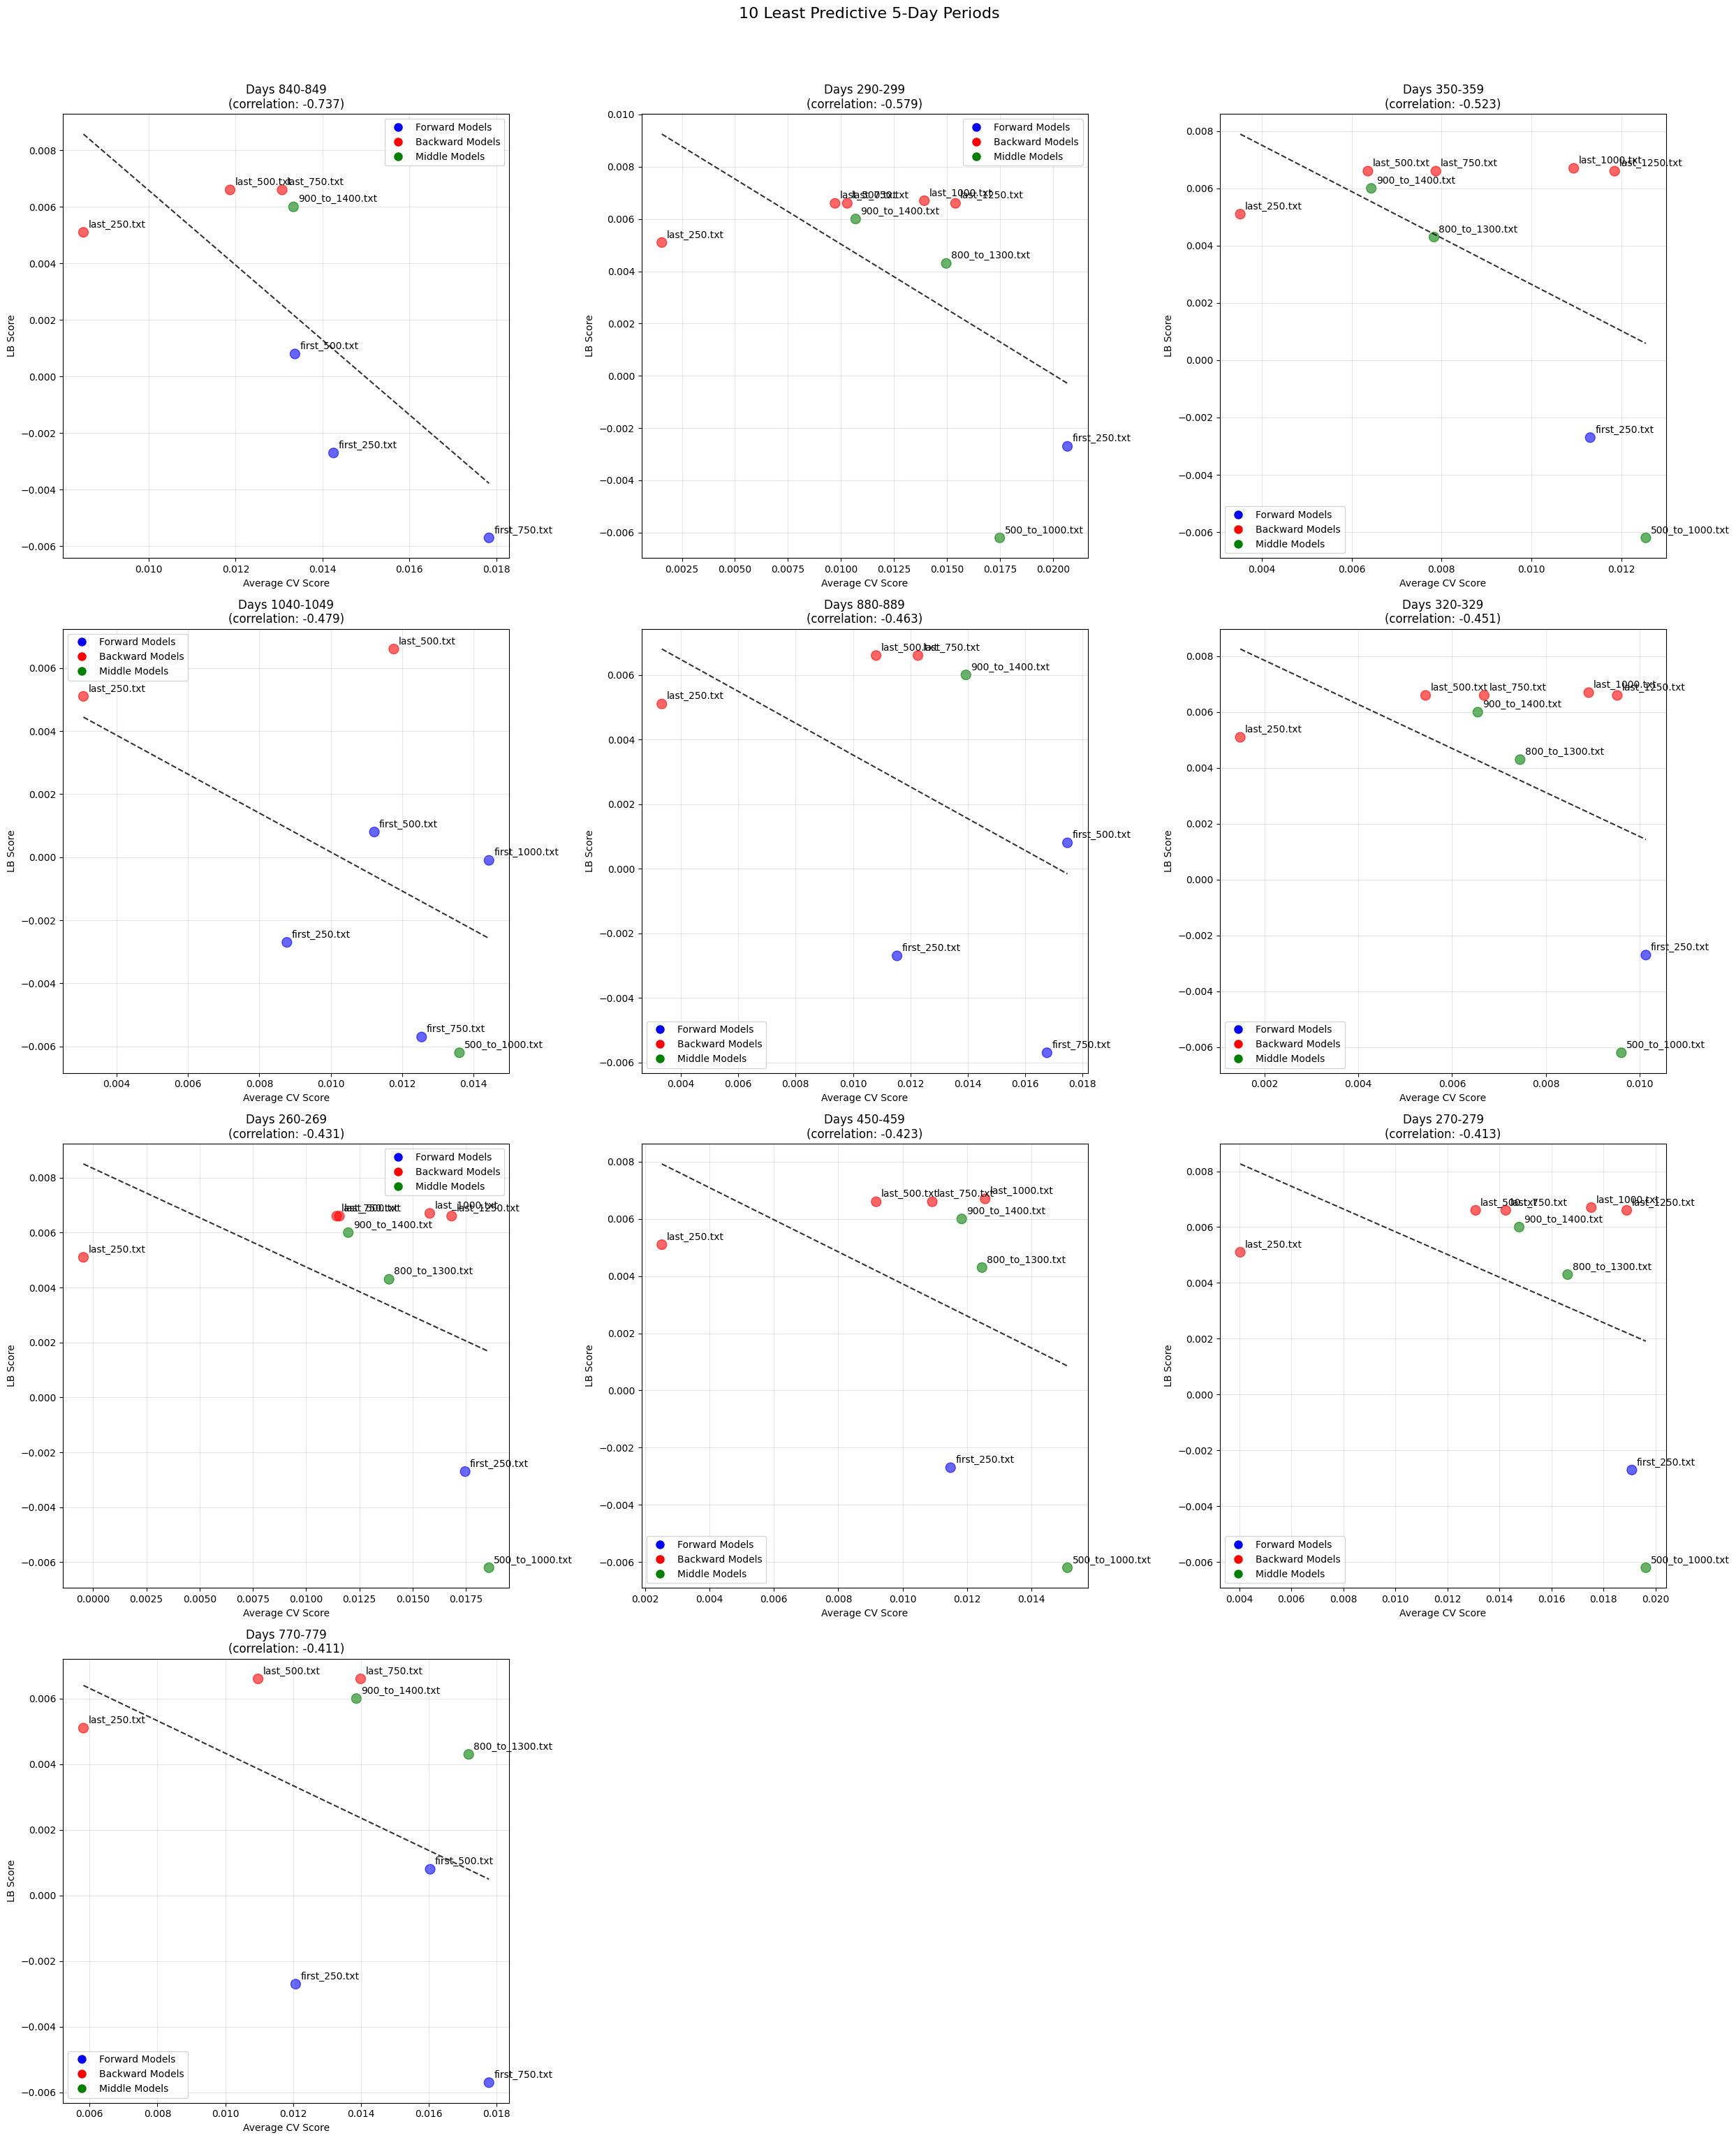


Total qualifying 5-day periods: 155
Average correlation: 0.099
Correlation std dev: 0.393

Top 10 most predictive periods:
--------------------------------------------------------------------------------

Days 1420-1429 (correlation: 0.965):
         500_to_1000.txt CV: -0.0165    LB: -0.0062   
         800_to_1300.txt CV:  0.0012    LB:  0.0043   
         900_to_1400.txt CV:  0.0050    LB:  0.0060   
         first_1000.txt  CV: -0.0029    LB: -0.0001   
         first_1250.txt  CV:  0.0007    LB:  0.0022   
         first_250.txt   CV: -0.0051    LB: -0.0027   
         first_500.txt   CV: -0.0013    LB:  0.0008   
         first_750.txt   CV: -0.0134    LB: -0.0057   
         last_250.txt    CV:  0.0022    LB:  0.0051   

Days 1640-1649 (correlation: 0.962):
         500_to_1000.txt CV: -0.0211    LB: -0.0062   
         800_to_1300.txt CV:  0.0056    LB:  0.0043   
         900_to_1400.txt CV:  0.0062    LB:  0.0060   
         first_1000.txt  CV: -0.0103    LB: -0.0001   
    

In [36]:
# Calculate correlation for each 5-day bin
bin_correlations = {}
bin_predictions = {}  
bin_size = 10

# Get min and max days
min_day = min(results_df['start_day'])
max_day = max(results_df['start_day'])

# Create bins
bins = list(range(min_day, max_day + bin_size, bin_size))

# Process each bin
for bin_start in bins:
    bin_end = bin_start + bin_size - 1
    day_scores = []
    lb_scores = []
    model_predictions = {}
    
    # Get all models' predictions for days in this bin
    for model_config in MODELS:
        model_name = model_config['name']
        train_start = model_config['train_start']
        train_end = model_config['train_end']
        r2_col = f'r2_score_{model_name}'
        
        # Get average score for this bin (outside training period)
        bin_mask = (results_df['start_day'] >= bin_start) & \
                  (results_df['start_day'] <= bin_end) & \
                  ((results_df['start_day'] < train_start) | \
                   (results_df['start_day'] > train_end))
        
        bin_scores = results_df[bin_mask][r2_col].dropna()
        
        if len(bin_scores) > 0:
            avg_score = bin_scores.mean()
            day_scores.append(avg_score)
            lb_scores.append(LB_SCORES[model_name])
            model_predictions[model_name] = (avg_score, LB_SCORES[model_name])
    
    # Calculate correlation if we have enough models
    if len(day_scores) >= 7:
        correlation = np.corrcoef(day_scores, lb_scores)[0,1]
        bin_correlations[bin_start] = correlation
        bin_predictions[bin_start] = model_predictions
    
# Get best and worst bins by correlation
top_bins = sorted(bin_correlations.items(), key=lambda x: x[1], reverse=True)[:10]
bottom_bins = sorted(bin_correlations.items(), key=lambda x: x[1])[:10]

# Function to create scatter plot for a bin
def plot_bin_correlation(ax, bin_start, correlation, predictions):
    day_scores = []
    lb_scores = []
    labels = []
    colors = []
    
    # Sort and prepare data
    sorted_predictions = sorted(predictions.items())
    for model_name, (day_score, lb_score) in sorted_predictions:
        day_scores.append(day_score)
        lb_scores.append(lb_score)
        labels.append(model_name)
        if model_name.startswith('first'):
            colors.append('blue')
        elif model_name.startswith('last'):
            colors.append('red')
        else:
            colors.append('green')
    
    # Create scatter plot
    scatter = ax.scatter(day_scores, lb_scores, c=colors, alpha=0.6, s=100)
    
    # Add trend line
    z = np.polyfit(day_scores, lb_scores, 1)
    p = np.poly1d(z)
    x_range = np.linspace(min(day_scores), max(day_scores), 100)
    ax.plot(x_range, p(x_range), "--", color='black', alpha=0.8, 
            label=f'Trend: y = {z[0]:.4f}x + {z[1]:.4f}')
    
    # Add labels
    for i, label in enumerate(labels):
        ax.annotate(label, (day_scores[i], lb_scores[i]), 
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=10)
    
    # Customize plot
    ax.set_title(f'Days {bin_start}-{bin_start+bin_size-1}\n(correlation: {correlation:.3f})', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('Average CV Score', fontsize=10)
    ax.set_ylabel('LB Score', fontsize=10)
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
                  label='Forward Models', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                  label='Backward Models', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', 
                  label='Middle Models', markersize=10)
    ]
    ax.legend(handles=legend_elements, loc='best', fontsize=10)

# Create subplot figures
fig, axes = plt.subplots(4, 3, figsize=(25, 30))
fig.suptitle('Top 10 Most Predictive 5-Day Periods', fontsize=16, y=1.02)
axes = axes.flatten()

for idx, (bin_start, correlation) in enumerate(top_bins):
    plot_bin_correlation(axes[idx], bin_start, correlation, bin_predictions[bin_start])

# Remove empty subplots
for idx in range(10, 12):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Create subplot figure for worst bins
fig, axes = plt.subplots(4, 3, figsize=(25, 30))
fig.suptitle('10 Least Predictive 5-Day Periods', fontsize=16, y=1.02)
axes = axes.flatten()

for idx, (bin_start, correlation) in enumerate(bottom_bins):
    plot_bin_correlation(axes[idx], bin_start, correlation, bin_predictions[bin_start])

# Remove empty subplots
for idx in range(10, 12):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nTotal qualifying 5-day periods: {len(bin_correlations)}")
print(f"Average correlation: {np.mean(list(bin_correlations.values())):.3f}")
print(f"Correlation std dev: {np.std(list(bin_correlations.values())):.3f}")

# Print top and bottom bins
for title, bins_list in [("Top 10 most predictive periods:", top_bins), 
                        ("Bottom 10 least predictive periods:", bottom_bins)]:
    print(f"\n{title}")
    print("-" * 80)
    for bin_start, correlation in bins_list:
        print(f"\nDays {bin_start}-{bin_start+bin_size-1} (correlation: {correlation:.3f}):")
        predictions = bin_predictions[bin_start]
        for model_name, (day_score, lb_score) in sorted(predictions.items()):
            print(f"{'':<8} {model_name:<15} CV: {day_score:< 10.4f} LB: {lb_score:< 10.4f}")

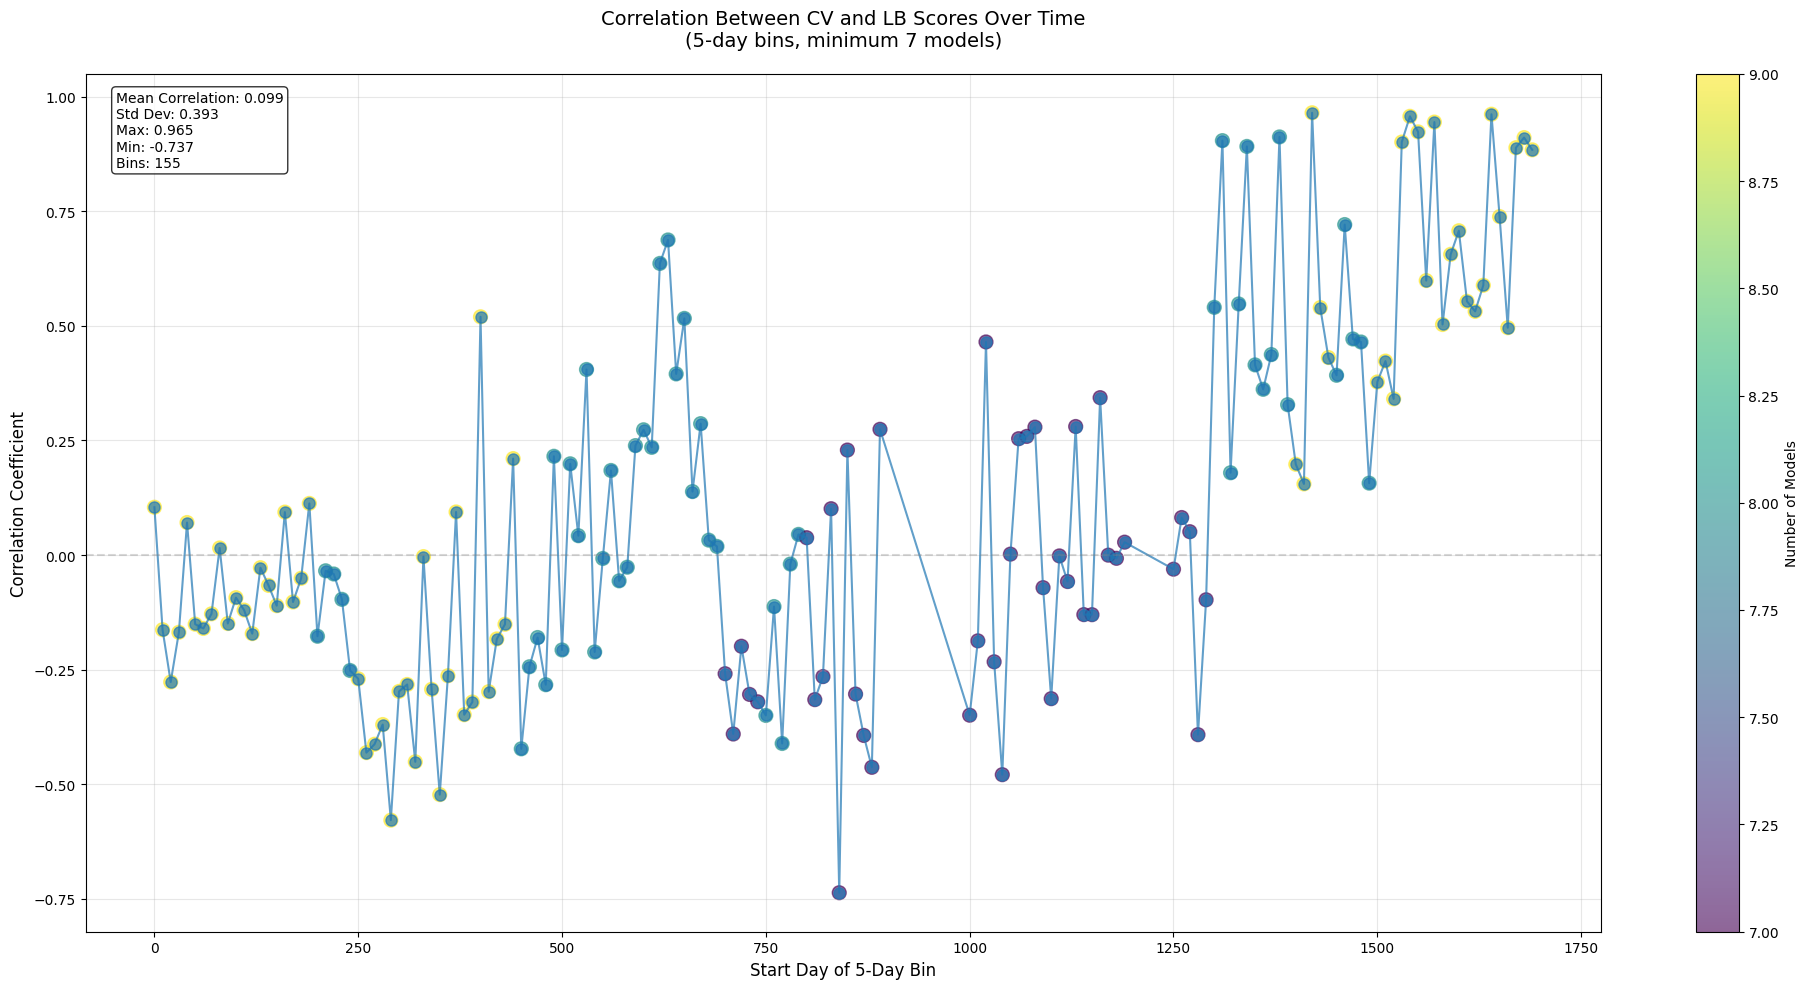

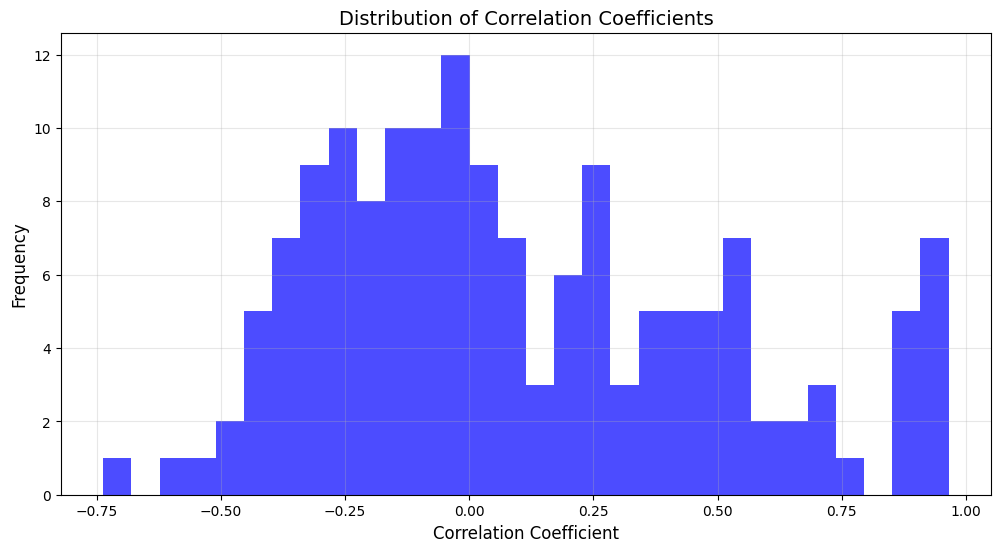


Correlation Statistics:
----------------------------------------
Number of bins: 155
Mean correlation: 0.099
Median correlation: 0.015
Std deviation: 0.393
Max correlation: 0.965
Min correlation: -0.737

Model Count Statistics:
----------------------------------------
Mean models per bin: 8.2
Max models per bin: 9
Min models per bin: 7


In [37]:
# Create figure for correlation over time
plt.figure(figsize=(20, 10))

# Get correlation data
bin_starts = list(bin_correlations.keys())
correlations = list(bin_correlations.values())
model_counts = [len(bin_predictions[bin_start]) for bin_start in bin_starts]

# Create main correlation plot
plt.plot(bin_starts, correlations, '-o', markersize=8, alpha=0.7, label='Correlation')

# Add horizontal line at y=0 for reference
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)

# Color the points based on number of models
scatter = plt.scatter(bin_starts, correlations, c=model_counts, cmap='viridis', 
                     s=100, alpha=0.6)
plt.colorbar(scatter, label='Number of Models')

# Customize plot
plt.title('Correlation Between CV and LB Scores Over Time\n(5-day bins, minimum 7 models)', 
          fontsize=14, pad=20)
plt.xlabel('Start Day of 5-Day Bin', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.grid(True, alpha=0.3)

# Add some statistics as text
stats_text = (f'Mean Correlation: {np.mean(correlations):.3f}\n'
             f'Std Dev: {np.std(correlations):.3f}\n'
             f'Max: {max(correlations):.3f}\n'
             f'Min: {min(correlations):.3f}\n'
             f'Bins: {len(correlations)}')
plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
         verticalalignment='top', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Create histogram of correlations
plt.figure(figsize=(12, 6))
plt.hist(correlations, bins=30, alpha=0.7, color='blue')
plt.title('Distribution of Correlation Coefficients', fontsize=14)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Print summary statistics
print("\nCorrelation Statistics:")
print("-" * 40)
print(f"Number of bins: {len(correlations)}")
print(f"Mean correlation: {np.mean(correlations):.3f}")
print(f"Median correlation: {np.median(correlations):.3f}")
print(f"Std deviation: {np.std(correlations):.3f}")
print(f"Max correlation: {max(correlations):.3f}")
print(f"Min correlation: {min(correlations):.3f}")
print("\nModel Count Statistics:")
print("-" * 40)
print(f"Mean models per bin: {np.mean(model_counts):.1f}")
print(f"Max models per bin: {max(model_counts)}")
print(f"Min models per bin: {min(model_counts)}")